## 1. Import Libraries

In [1]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

'pkill' is not recognized as an internal or external command,
operable program or batch file.
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


PyTorch version: 2.9.1+cu128
Device: cuda


In [2]:
base_path = Path.cwd().resolve()

datasets_path = base_path / "an2dl2526c2"
if not datasets_path.exists():
    fallback_path = base_path.parent / "an2dl2526c2"
    if fallback_path.exists():
        datasets_path = fallback_path
    else:
        raise FileNotFoundError(f"Dataset folder not found at {datasets_path} or {fallback_path}")

train_data_path = datasets_path / "train_data"
train_labels_path = datasets_path / "train_labels.csv"
test_data_path = datasets_path / "test_data"
output_path = datasets_path / "train_masked"

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Output path: {output_path}")

CSV_PATH = str(train_labels_path)
SOURCE_FOLDER = str(train_data_path)
OUTPUT_FOLDER = str(output_path)
TEST_IMAGE_PATH = str(test_data_path)
# if not Path(SOURCE_FOLDER).exists():
#     candidate_datasets = [
#         datasets_path,
#         base_path.parent / "an2dl2526c2",
#         Path(r"C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2"),
#     ]
#     for candidate in candidate_datasets:
#         if candidate.exists():
#             datasets_path = candidate
#             train_data_path = datasets_path / "train_data"
#             train_labels_path = datasets_path / "train_labels.csv"
#             test_data_path = datasets_path / "test_data"
#             output_path = datasets_path / "train_masked"

#             CSV_PATH = str(train_labels_path)
#             SOURCE_FOLDER = str(train_data_path)
#             OUTPUT_FOLDER = str(output_path)

#             print(f"Resolved dataset path: {datasets_path}")
#             break
#     else:
#         raise FileNotFoundError(
#             "Dataset folder not found in any of the candidate locations:\n"
#             + "\n".join(str(p) for p in candidate_datasets)
#         )

Dataset path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2
Train data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Train labels path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels.csv
Test data path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\test_data
Output path: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked


In [3]:
def apply_mask(image_path, mask_path, output_path, target_size=(224, 224)):
    """
    Loads an image and a mask, resizes them, applies the mask, and saves the result.
    """
    # 1. Load Image
    img = cv2.imread(str(image_path))
    if img is None:
        tqdm.write(f"Error: Could not load image at {image_path}")
        return

    # 2. Load Mask (Read as grayscale)
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        tqdm.write(f"Error: Could not load mask at {mask_path}")
        return

    # 3. Resize both to target size
    if target_size is not None:
        # Resize image using linear interpolation (better for photos)
        img = cv2.resize(img, target_size)
        # Resize mask using nearest neighbor to preserve sharp edges
        mask = cv2.resize(mask, target_size)

    # 4. Ensure mask is strictly binary (0 or 255)
    # Values > 127 become 255 (White), others become 0 (Black)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Apply the mask
    # cv2.bitwise_and keeps the pixel where the mask is 255, and makes it 0 where mask is 0
    # added multiply opencv method for computing image and mask element-wise multiplication
    masked_img = cv2.bitwise_and(img, img, mask=binary_mask)
    #masked_img = cv2.multiply(img, (binary_mask[:, :, np.newaxis] // 255).astype(img.dtype))

    # 6. Save result
    cv2.imwrite(str(output_path), masked_img)

In [4]:
def process_batch(input_dir, output_dir, target_size=(224, 224)):
    """
    Iterates through input_dir, finds pairs of 'img_xxxx' and 'mask_xxxx',
    resizes them to target_size, and saves the masked result to output_dir.
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    
    # Create output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Extensions to look for
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    # 1. Gather all valid image files first
    print(f"Scanning for images in: {input_dir}...")
    image_files = [
        f for f in input_dir.iterdir() 
        if f.name.startswith('img_') and f.suffix.lower() in valid_extensions
    ]
    
    if not image_files:
        print("No images found starting with 'img_' in the directory.")
        return

    # 2. Iterate with tqdm
    count = 0
    
    for file_path in tqdm(image_files, desc="Processing Images", unit="img"):
        # Construct expected mask filename: img_123.jpg -> mask_123.jpg
        mask_name = file_path.name.replace('img_', 'mask_', 1)
        mask_path = input_dir / mask_name
        
        # Fallback: If mask_123.jpg doesn't exist, try mask_123.png
        if not mask_path.exists():
            mask_stem = file_path.stem.replace('img_', 'mask_', 1)
            mask_path = input_dir / (mask_stem + ".png")
        
        if mask_path.exists():
            output_path = output_dir / file_path.name
            
            if output_path.exists():
                # Skip silently
                continue

            apply_mask(file_path, mask_path, output_path, target_size=target_size)
            count += 1
        else:
            # Use tqdm.write to log errors without breaking the progress bar
            tqdm.write(f"Skipping {file_path.name}: No matching mask found (looked for {mask_name})")

    print(f"Batch processing complete. Processed {count} new images.")

In [5]:
def load_images_from_folder(folder, target_size=(224, 224)):
    """
    Load and preprocess images from a specified folder with a progress bar.

    Args:
        folder (str): Path to the folder containing images
        target_size (tuple): Target size for resizing images (default: (224, 224))

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []
    shape_counts = {}  # Track different shapes to diagnose issues
    
    # Get the list of files to iterate over
    file_list = os.listdir(folder)

    # Iterate through files with a tqdm progress bar
    for filename in tqdm(file_list, desc=f"Loading images from {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Check if image was loaded successfully right away
        if img is None:
            print(f"Warning: Failed to load image at {img_path}. Skipping.")
            continue

        # Track shapes before resizing
        original_shape = img.shape
        if original_shape not in shape_counts:
            shape_counts[original_shape] = 0
        shape_counts[original_shape] += 1

        # Resize image to ensure uniform dimensions
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255.0).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[..., ::-1]

        images.append(img)

    # Print shape statistics
    if len(shape_counts) > 1:
        print(f"\nFound {len(shape_counts)} different image shapes:")
        for shape, count in sorted(shape_counts.items()):
            print(f"  Shape {shape}: {count} images")
    
    return np.array(images)

In [6]:
source_dir = Path(SOURCE_FOLDER)
output_dir = Path(OUTPUT_FOLDER)

TARGET_SIZE = (224, 224)

if not source_dir.exists():
	print(f"Warning: source directory '{source_dir}' not found. Creating an empty directory. Please populate it with images before running the pipeline.")
	source_dir.mkdir(parents=True, exist_ok=True)

output_dir.mkdir(parents=True, exist_ok=True)

process_batch(str(source_dir), str(output_dir), target_size=TARGET_SIZE)
MASKED_IMAGE_PATH = str(output_dir)

Scanning for images in: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data...


Processing Images:   0%|          | 0/691 [00:00<?, ?img/s]

Processing Images: 100%|██████████| 691/691 [00:16<00:00, 40.99img/s]

Batch processing complete. Processed 691 new images.


## **3. Exploration and Data Analysis**

In [7]:
# Loading the processed images
train_images = load_images_from_folder(MASKED_IMAGE_PATH)

# Add this cell before your visualization
print(f"MASKED_IMAGE_PATH: {MASKED_IMAGE_PATH}")
print(f"Path exists: {Path(MASKED_IMAGE_PATH).exists()}")
print(f"Number of files: {len(os.listdir(MASKED_IMAGE_PATH)) if Path(MASKED_IMAGE_PATH).exists() else 0}")
print(f"train_images shape: {train_images.shape}")

Loading images from train_masked: 100%|██████████| 691/691 [00:07<00:00, 94.87it/s] 


MASKED_IMAGE_PATH: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_masked
Path exists: True
Number of files: 691
train_images shape: (691, 224, 224, 3)


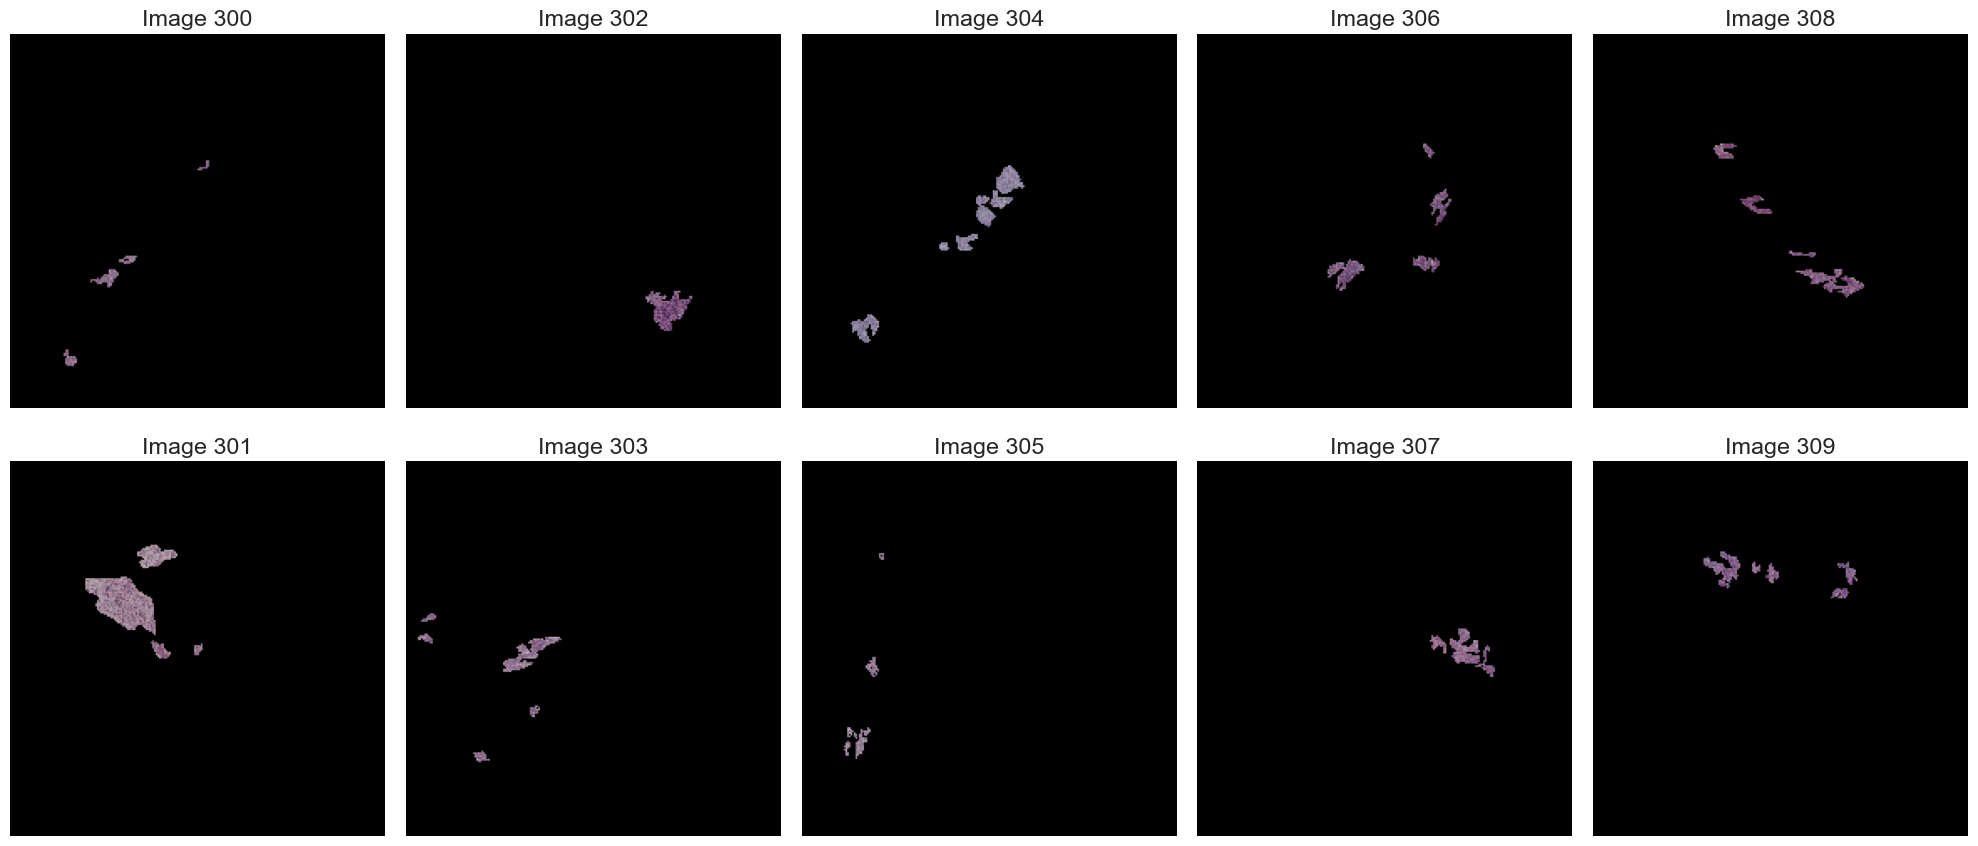

In [8]:
# Number of images to display
num_img = 10
start_img= 300
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    # Add the image index into the imageshow
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()



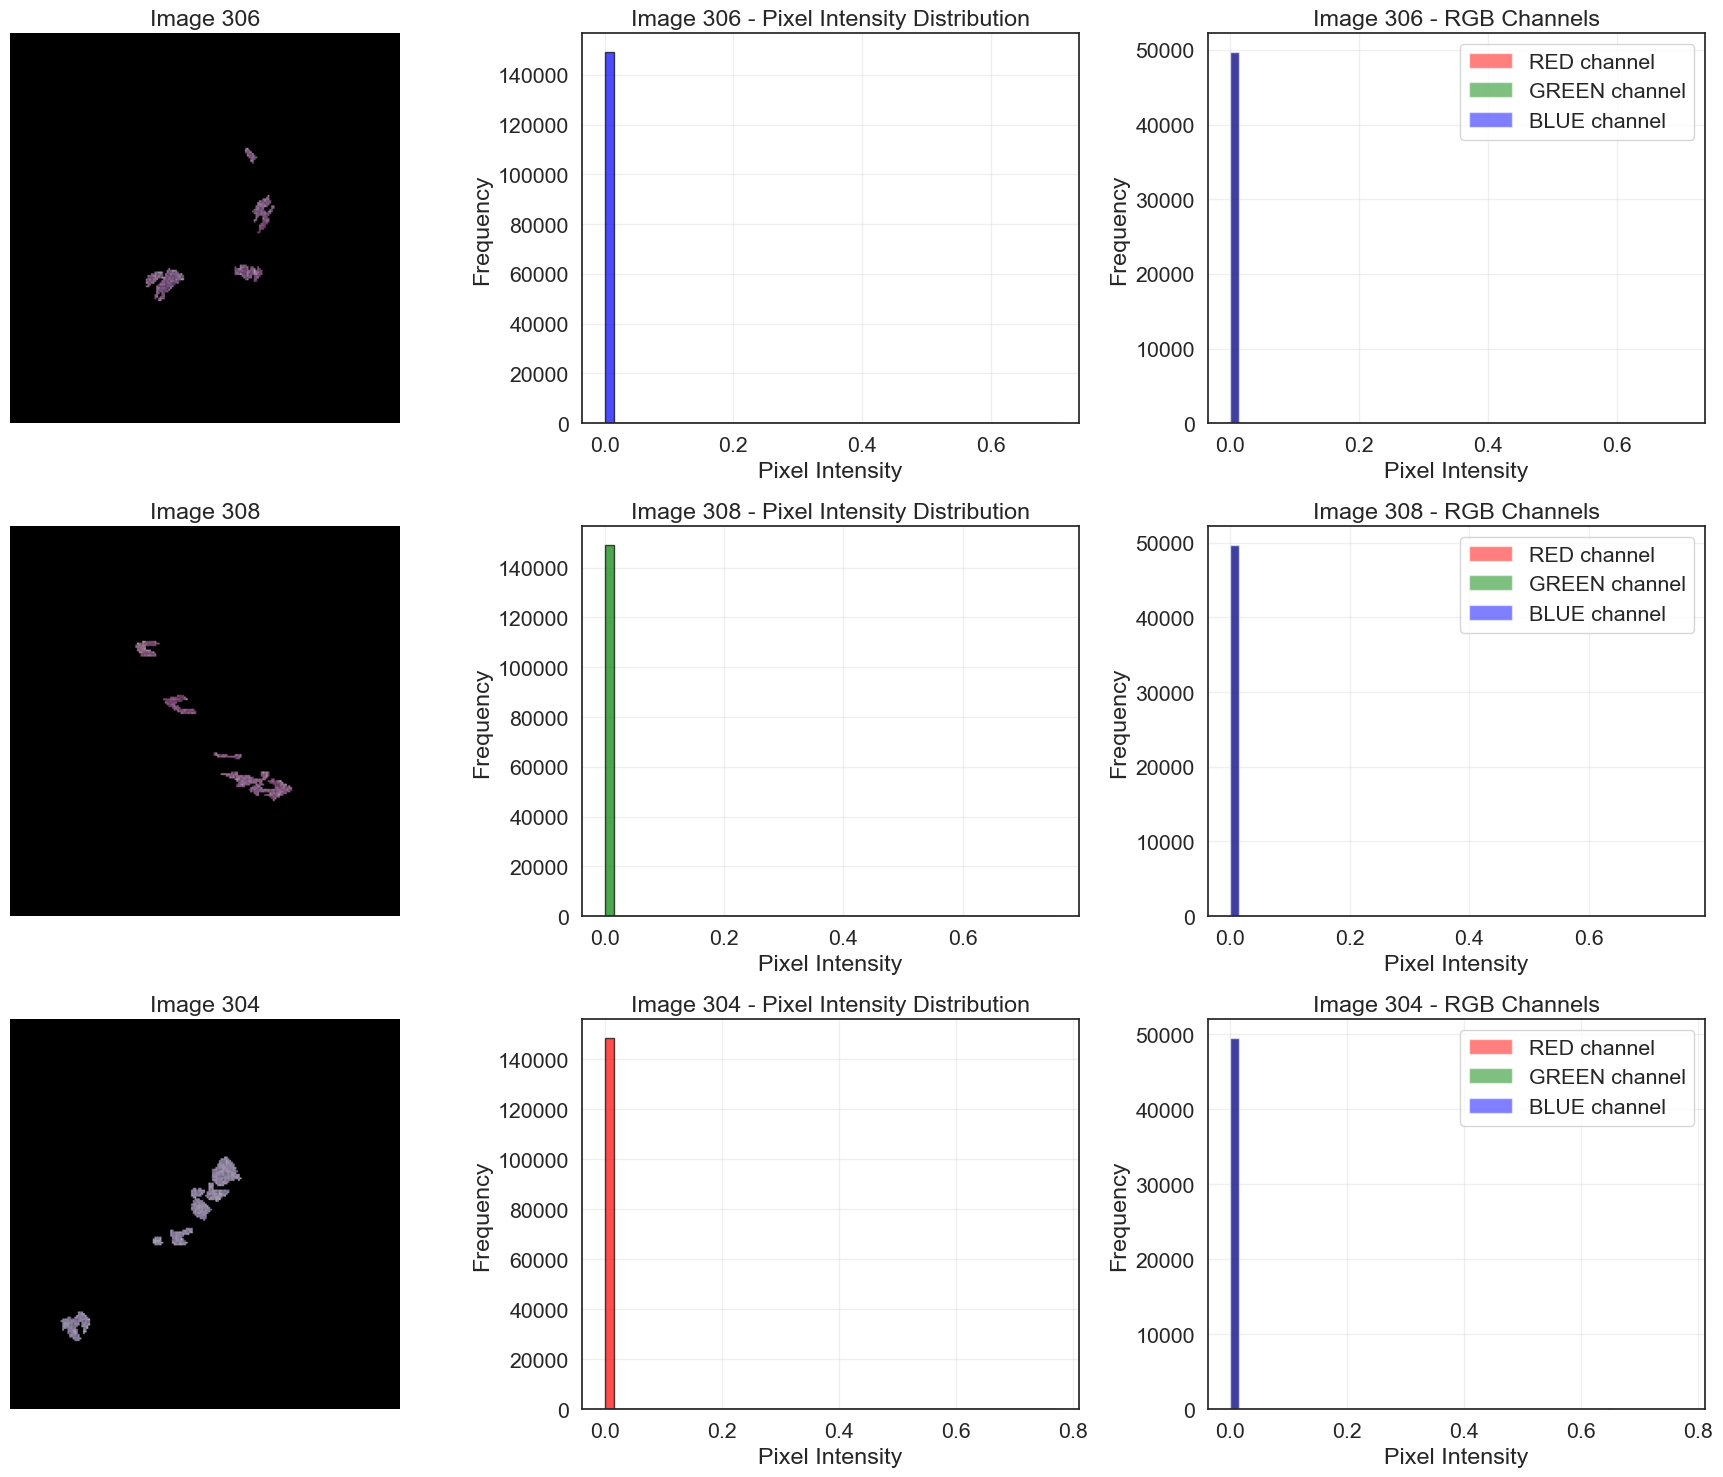

Image 306 Statistics:
  Mean intensity: 0.0039
  Std deviation: 0.0427
  Min: 0.0000, Max: 0.7020

Image 308 Statistics:
  Mean intensity: 0.0042
  Std deviation: 0.0447
  Min: 0.0000, Max: 0.7569

Image 304 Statistics:
  Mean intensity: 0.0073
  Std deviation: 0.0641
  Min: 0.0000, Max: 0.7725

Green Channel Statistics:
Image 304 - Green channel mean: 0.0067, std: 0.0587
Image 308 - Green channel mean: 0.0033, std: 0.0352

Red Channel Statistics:
Image 304 - Red channel mean: 0.0072, std: 0.0629
Image 308 - Red channel mean: 0.0048, std: 0.0498

Blue Channel Statistics:
Image 304 - Blue channel mean: 0.0080, std: 0.0702
Image 308 - Blue channel mean: 0.0046, std: 0.0476


In [9]:
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]
img_304 = train_images[304]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Display Image 306
axes[0, 0].imshow(np.clip(img_306, 0, 1))
axes[0, 0].set_title("Image 306")
axes[0, 0].axis('off')

# Display Image 308
axes[1, 0].imshow(np.clip(img_308, 0, 1))
axes[1, 0].set_title("Image 308")
axes[1, 0].axis('off')

# Display Image 304
axes[2, 0].imshow(np.clip(img_304, 0, 1))
axes[2, 0].set_title("Image 304")
axes[2, 0].axis('off')

# Pixel intensity histogram for Image 306 (all channels combined)
axes[0, 1].hist(img_306.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title("Image 306 - Pixel Intensity Distribution")
axes[0, 1].set_xlabel("Pixel Intensity")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].grid(True, alpha=0.3)

# Pixel intensity histogram for Image 308 (all channels combined)
axes[1, 1].hist(img_308.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_title("Image 308 - Pixel Intensity Distribution")
axes[1, 1].set_xlabel("Pixel Intensity")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].grid(True, alpha=0.3)

# Pixel intensity histograms for Image 304
axes[2, 1].hist(img_304.flatten(), bins=50, color='red', alpha=0.7, edgecolor='black')
axes[2, 1].set_title("Image 304 - Pixel Intensity Distribution")
axes[2, 1].set_xlabel("Pixel Intensity")
axes[2, 1].set_ylabel("Frequency")
axes[2, 1].grid(True, alpha=0.3)

# RGB channel histograms for Image 306
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[0, 2].hist(img_306[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[0, 2].set_title("Image 306 - RGB Channels")
axes[0, 2].set_xlabel("Pixel Intensity")
axes[0, 2].set_ylabel("Frequency")
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 308
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[1, 2].hist(img_308[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[1, 2].set_title("Image 308 - RGB Channels")
axes[1, 2].set_xlabel("Pixel Intensity")
axes[1, 2].set_ylabel("Frequency")
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# RGB channel histograms for Image 304
for channel, color in enumerate(['red', 'green', 'blue']):
    axes[2, 2].hist(img_304[:, :, channel].flatten(), bins=50, 
                    color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[2, 2].set_title("Image 304 - RGB Channels")
axes[2, 2].set_xlabel("Pixel Intensity")
axes[2, 2].set_ylabel("Frequency")
axes[2, 2].legend()
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Image 306 Statistics:")
print(f"  Mean intensity: {img_306.mean():.4f}")
print(f"  Std deviation: {img_306.std():.4f}")
print(f"  Min: {img_306.min():.4f}, Max: {img_306.max():.4f}")

print("\nImage 308 Statistics:")
print(f"  Mean intensity: {img_308.mean():.4f}")
print(f"  Std deviation: {img_308.std():.4f}")
print(f"  Min: {img_308.min():.4f}, Max: {img_308.max():.4f}")

print("\nImage 304 Statistics:")
print(f"  Mean intensity: {img_304.mean():.4f}")
print(f"  Std deviation: {img_304.std():.4f}")
print(f"  Min: {img_304.min():.4f}, Max: {img_304.max():.4f}")

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Green channel mean: {img_304[:, :, 1].mean():.4f}, std: {img_304[:, :, 1].std():.4f}")
print(f"Image 308 - Green channel mean: {img_308[:, :, 1].mean():.4f}, std: {img_308[:, :, 1].std():.4f}")

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Red channel mean: {img_304[:, :, 0].mean():.4f}, std: {img_304[:, :, 0].std():.4f}")
print(f"Image 308 - Red channel mean: {img_308[:, :, 0].mean():.4f}, std: {img_308[:, :, 0].std():.4f}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Blue channel mean: {img_304[:, :, 2].mean():.4f}, std: {img_304[:, :, 2].std():.4f}")
print(f"Image 308 - Blue channel mean: {img_308[:, :, 2].mean():.4f}, std: {img_308[:, :, 2].std():.4f}")


Analyzing green channel frequency for all images...


Analyzing images: 100%|██████████| 691/691 [00:00<00:00, 6495.06it/s]


Top 20 images with highest green intensity frequency (>0.5):
Index | High Green % | Dominant Green %
--------------------------------------------------
  538 |       11.30% |            0.01%
   18 |       11.27% |            4.96%
  389 |        9.06% |            0.08%
  530 |        6.79% |            4.95%
  391 |        6.55% |            0.01%
  645 |        6.54% |            4.94%
  656 |        6.40% |            5.02%
  643 |        6.28% |            4.95%
  182 |        6.00% |            0.00%
  222 |        5.97% |            4.95%
  657 |        5.77% |            4.95%
   78 |        5.76% |            4.97%
  368 |        5.74% |            4.94%
   28 |        5.65% |            4.94%
   44 |        5.63% |            4.94%
  184 |        5.62% |            4.95%
    1 |        5.60% |            4.93%
  342 |        5.52% |            4.96%
  588 |        5.48% |            0.02%
  407 |        5.48% |            4.95%


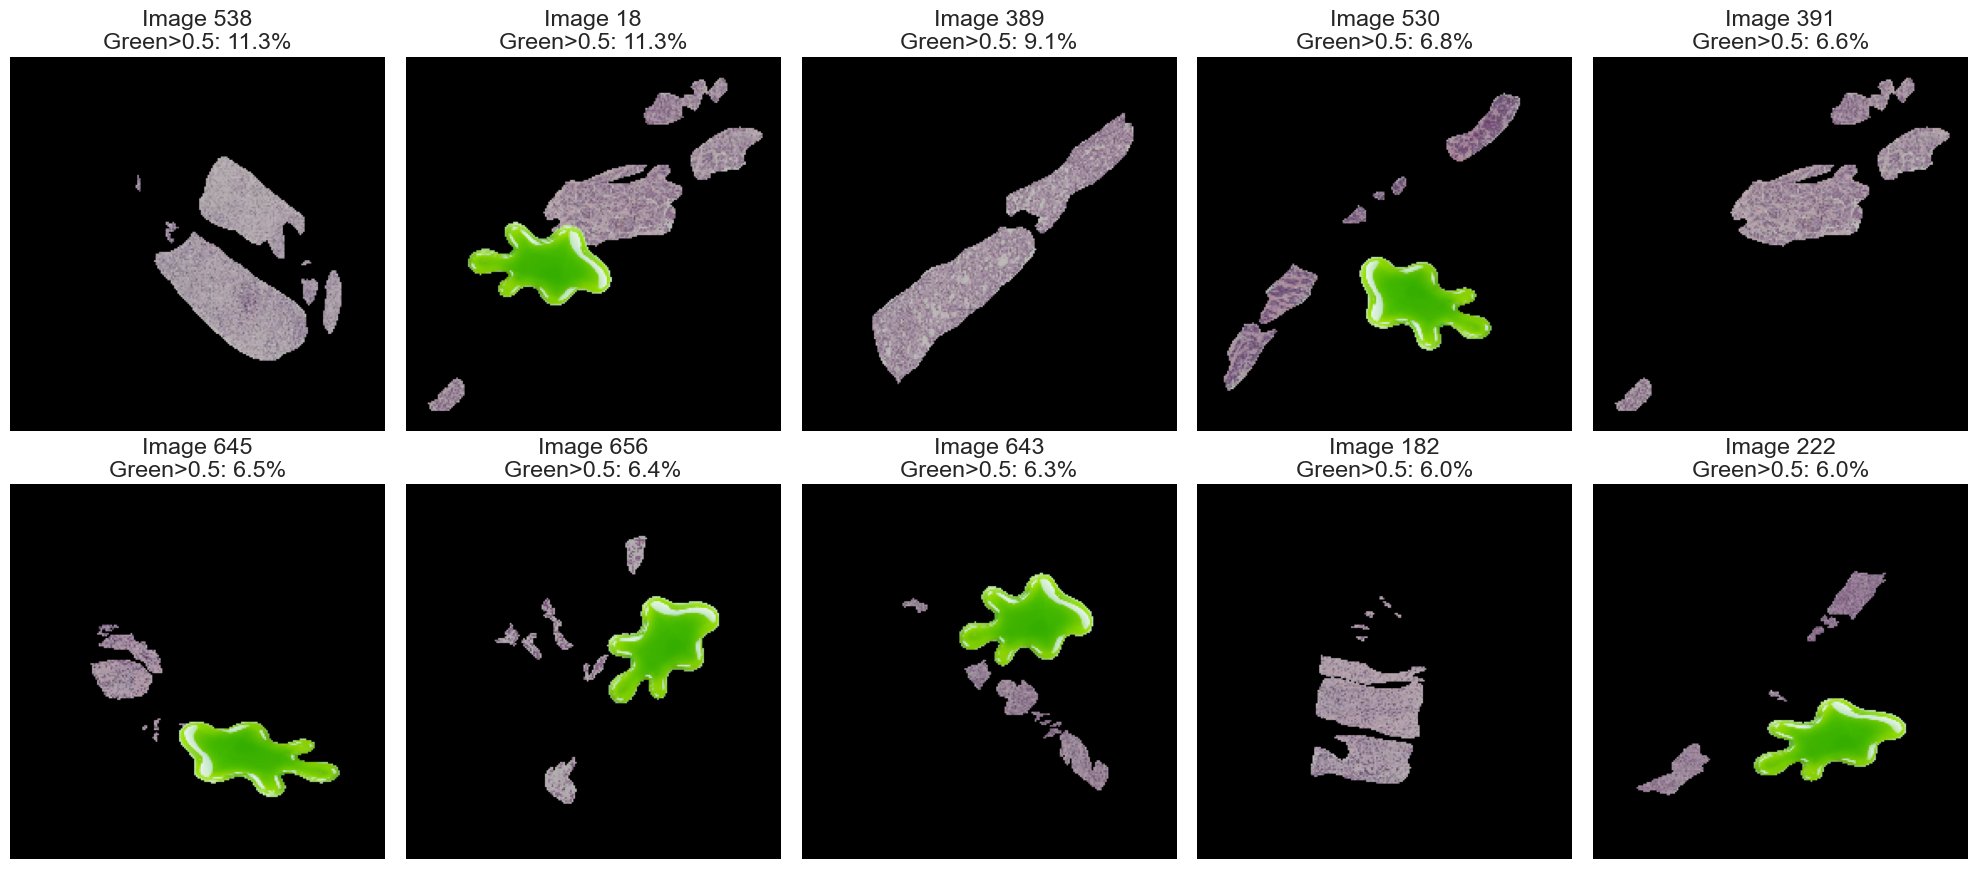


Selected 0 images with >20.0% high green intensity
Indices: []

Stored 0 images in 'selected_green_images' array
Shape: (0, 224, 224, 3)


In [10]:
# Identify images with high green channel intensity frequency
# Based on the histogram analysis, select images where green channel dominates

def analyze_green_frequency(image):
    """
    Analyze green channel frequency distribution.
    Returns the percentage of pixels where green channel has high intensity (>0.5)
    and where green is the dominant channel.
    """
    green_channel = image[:, :, 1]
    
    # Count pixels with high green intensity (>0.5)
    high_green_pixels = np.sum(green_channel > 0.5)
    
    # Count pixels where green is dominant (G > R and G > B)
    green_dominant = np.sum(
        (image[:, :, 1] > image[:, :, 0]) & 
        (image[:, :, 1] > image[:, :, 2])
    )
    
    total_pixels = image.shape[0] * image.shape[1]
    high_green_percentage = (high_green_pixels / total_pixels) * 100
    dominant_green_percentage = (green_dominant / total_pixels) * 100
    
    return high_green_percentage, dominant_green_percentage

# Analyze all images
print("Analyzing green channel frequency for all images...")
green_analysis = []
for idx, img in enumerate(tqdm(train_images, desc="Analyzing images")):
    high_green_pct, dominant_green_pct = analyze_green_frequency(img)
    green_analysis.append({
        'index': idx,
        'high_green_pct': high_green_pct,
        'dominant_green_pct': dominant_green_pct
    })

# Convert to DataFrame for easy sorting
df_green = pd.DataFrame(green_analysis)

# Sort by high green intensity percentage
df_sorted_high = df_green.sort_values('high_green_pct', ascending=False)

# Display top 20 images with highest green intensity frequency
print("\nTop 20 images with highest green intensity frequency (>0.5):")
print("Index | High Green % | Dominant Green %")
print("-" * 50)
for _, row in df_sorted_high.head(20).iterrows():
    print(f"{int(row['index']):5d} | {row['high_green_pct']:11.2f}% | {row['dominant_green_pct']:15.2f}%")

# Visualize top 10 images with highest green frequency
fig, axes = plt.subplots(2, 5, figsize=(20, 9))
axes = axes.flatten()
for i, (_, row) in enumerate(df_sorted_high.head(10).iterrows()):
    idx = int(row['index'])
    axes[i].imshow(np.clip(train_images[idx], 0, 1))
    axes[i].set_title(f"Image {idx}\nGreen>0.5: {row['high_green_pct']:.1f}%")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Select images based on threshold
green_threshold = 20.0  # Select images with >20% high green intensity
selected_green_indices = df_green[df_green['high_green_pct'] > green_threshold]['index'].values.astype(int).tolist()

print(f"\nSelected {len(selected_green_indices)} images with >{green_threshold}% high green intensity")
print(f"Indices: {selected_green_indices[:50]}")  # Show first 50

# Store the selected images
selected_green_images = train_images[selected_green_indices]
print(f"\nStored {len(selected_green_images)} images in 'selected_green_images' array")
print(f"Shape: {selected_green_images.shape}")

## **3. Exploration and Data Analysis**

### Green Area Removal Filter

In [11]:
def filter_bright_green_areas(image, lg_H=60-50, lg_S=10, lg_V=50, ug_H=60+50, ug_S=255, ug_V=255, dilate_iterations=2):
    """ 
    Filters out bright green areas from the input image with improved residual removal.
    
    Args:
        image: Input image in RGB format (0-1 range)
        lg_H, lg_S, lg_V: Lower bounds for HSV green detection
        ug_H, ug_S, ug_V: Upper bounds for HSV green detection
        dilate_iterations: Number of dilation iterations to expand mask (removes edge artifacts)
    """

    # Convert from RGB (0-1) to BGR (0-255) for OpenCV
    original_bgr = (image * 255).astype(np.uint8)[..., ::-1]

    # 1. Convert to HSV (Hue, Saturation, Value)
    hsv = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2HSV)

    # 2. Define the "Bright Green" Range
    lower_green = (lg_H, lg_S, lg_V)
    upper_green = (ug_H, ug_S, ug_V)

    # Create the initial mask
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # 3. Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # OPEN: Remove small noise
    clean_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    # DILATE: Expand the mask to catch edge artifacts and residuals
    # This ensures we remove green pixels at the boundaries
    if dilate_iterations > 0:
        clean_mask = cv2.dilate(clean_mask, kernel, iterations=dilate_iterations)

    # 4. Additional step: Detect any remaining green-ish pixels
    # Create a more aggressive mask for subtle green tones
    lower_green_subtle = (max(0, lg_H - 10), max(0, lg_S - 10), 0)
    upper_green_subtle = (min(180, ug_H + 10), 255, 255)
    subtle_mask = cv2.inRange(hsv, lower_green_subtle, upper_green_subtle)
    
    # Only keep subtle green pixels that are near the main green area
    subtle_mask = cv2.morphologyEx(subtle_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Combine masks
    combined_mask = cv2.bitwise_or(clean_mask, subtle_mask)

    # 5. Invert mask to keep the useful parts
    mask_inv = cv2.bitwise_not(combined_mask)

    # 6. Apply the mask
    result_bgr = cv2.bitwise_and(original_bgr, original_bgr, mask=mask_inv)

    return result_bgr, combined_mask

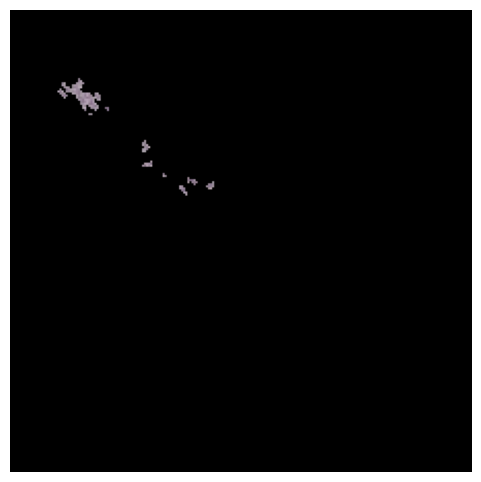

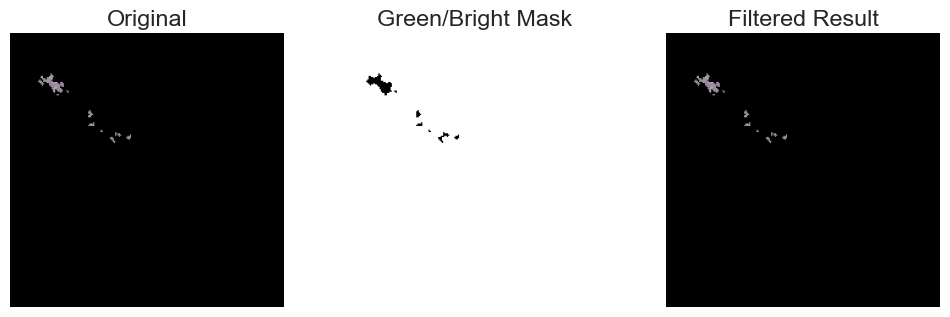

In [12]:
# Display the pixels values of an image with green areas
image_index = 102
image = train_images[image_index]
plt.figure(figsize=(6, 6))
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')
plt.show()

result_bgr, clean_mask = filter_bright_green_areas(image)

# --- Display Results ---
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(image, 0, 1))
plt.axis('off')

# The Mask (Visualizing what we are removing)
plt.subplot(1, 3, 2)
plt.title("Green/Bright Mask")
plt.imshow(clean_mask, cmap='gray')
plt.axis('off')

# Result
result_rgb = result_bgr[..., ::-1]
plt.subplot(1, 3, 3)
plt.title("Filtered Result")
plt.imshow(np.clip(result_rgb / 255.0, 0, 1))
plt.axis('off')

plt.show()

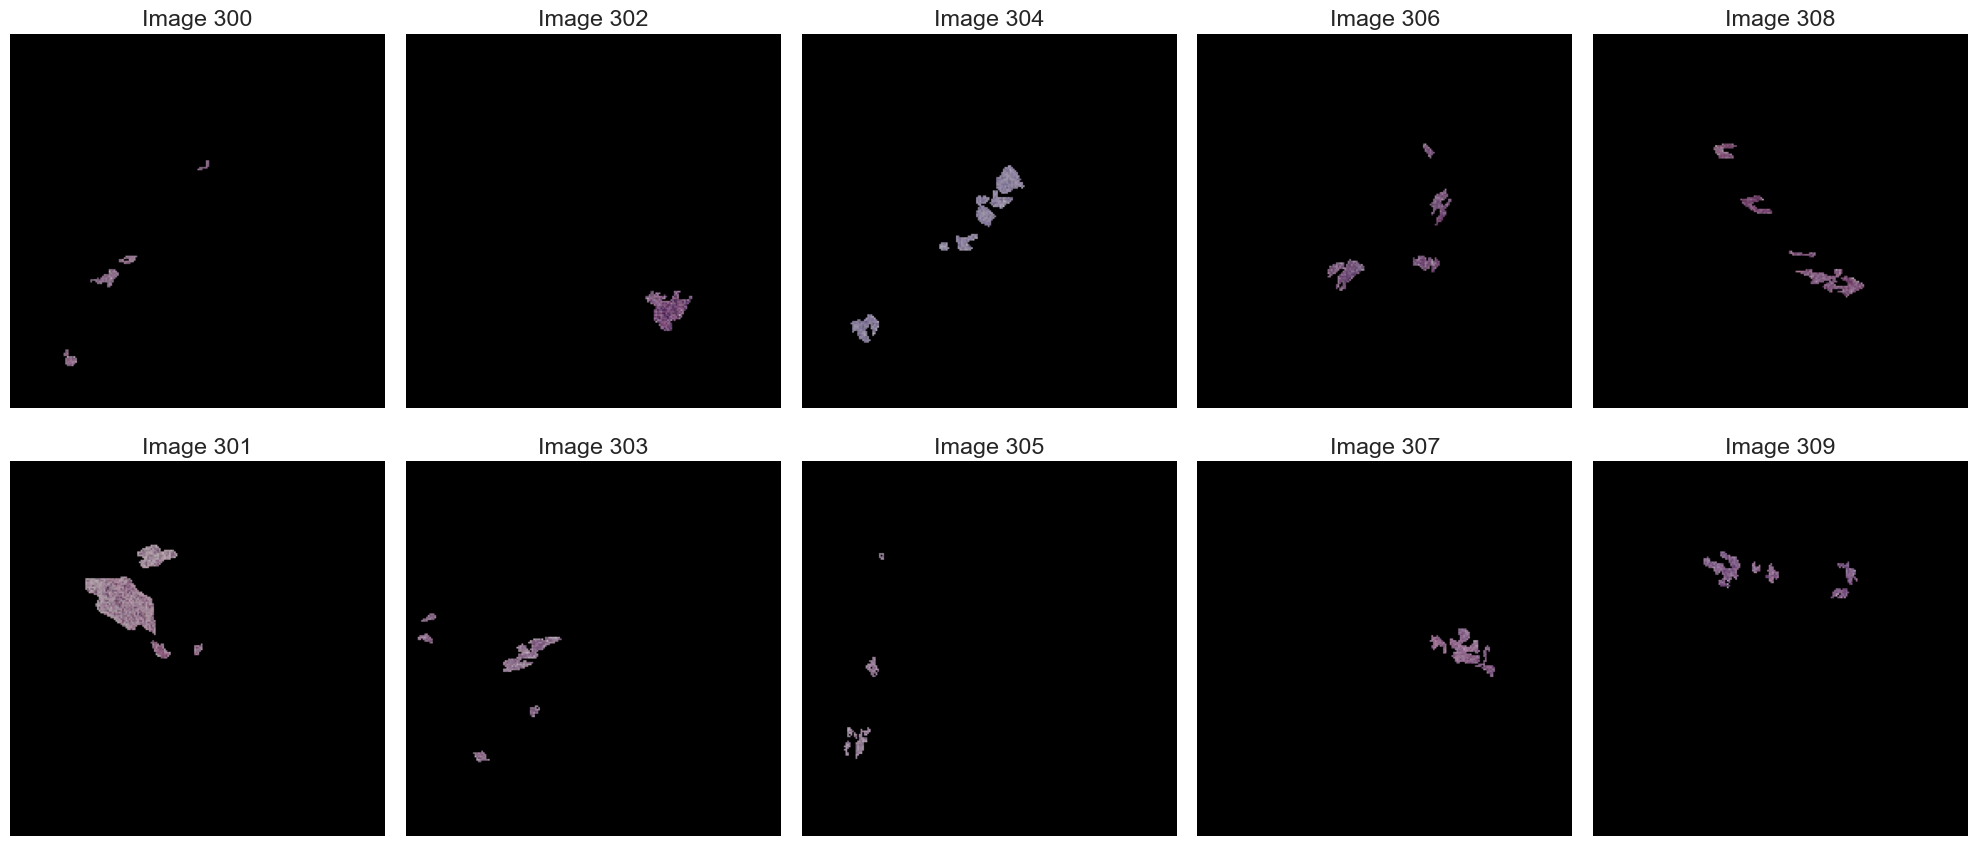

In [13]:
# Convert from BGR to RGB for displaying
result_rgb = result_bgr[..., ::-1]


# Apply the HSV filter for all the images into the training set and normalize them
for image in train_images:
    filtered_bgr, _ = filter_bright_green_areas(image)
    # Convert back to RGB and normalize to [0, 1]
    filtered_rgb = filtered_bgr[..., ::-1] / 255.0
    # Update the image in place
    image[:] = filtered_rgb

# Number of images to display
num_img = 10
start_img= 300
# Create again subplots for displaying the filtered items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(start_img, start_img+num_img):
    ax = axes[i%2, i%num_img//2]
    ax.set_title(f"Image {i}")
    ax.imshow(np.clip(train_images[i], 0, 1))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()


In [14]:
# Print RBG channel for 308 and 304 images
# Compare pixel intensity distributions for images 306 and 308
img_306 = train_images[306]
img_308 = train_images[308]

img_304 = train_images[304]

# Print green channel statistics for images 304 and 308
print("\nGreen Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 1].mean()}, Std: {img_304[..., 1].std()}")
print(f"Image 308 - Mean: {img_308[..., 1].mean()}, Std: {img_308[..., 1].std()}")
print(f"Image 306 - Mean: {img_306[..., 1].mean()}, Std: {img_306[..., 1].std()}")

# Print blue channel statistics for images 304 and 308
print("\nBlue Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 2].mean()}, Std: {img_304[..., 2].std()}")
print(f"Image 308 - Mean: {img_308[..., 2].mean()}, Std: {img_308[..., 2].std()}")
print(f"Image 306 - Mean: {img_306[..., 2].mean()}, Std: {img_306[..., 2].std()}")  

# Print red channel statistics for images 304 and 308
print("\nRed Channel Statistics:")
print(f"Image 304 - Mean: {img_304[..., 0].mean()}, Std: {img_304[..., 0].std()}")
print(f"Image 308 - Mean: {img_308[..., 0].mean()}, Std: {img_308[..., 0].std()}")

# Overall statistics
print("\nOverall Image Statistics After Filtering:")
print(f"Image 304 - Mean: {img_304.mean()}, Std: {img_304.std()}")
print(f"Image 308 - Mean: {img_308.mean()}, Std: {img_308.std()}")


Green Channel Statistics:
Image 304 - Mean: 0.006672747433185577, Std: 0.05873456224799156
Image 308 - Mean: 0.0033002265263348818, Std: 0.035069119185209274
Image 306 - Mean: 0.003165406873449683, Std: 0.03434978798031807

Blue Channel Statistics:
Image 304 - Mean: 0.008002419956028461, Std: 0.07019992172718048
Image 308 - Mean: 0.0045481473207473755, Std: 0.04750778153538704
Image 306 - Mean: 0.004378235433250666, Std: 0.046720925718545914

Red Channel Statistics:
Image 304 - Mean: 0.007154971826821566, Std: 0.0628957748413086
Image 308 - Mean: 0.004760029260069132, Std: 0.04966842755675316

Overall Image Statistics After Filtering:
Image 304 - Mean: 0.007276712451130152, Std: 0.06412114202976227
Image 308 - Mean: 0.004202800802886486, Std: 0.04455345496535301


In [15]:
# Remove images that have a overall mean lower or equal then 0.001
MEAN_LIMIT = 0.0001
tot_eliminated_imgs = []
kept_images = []
indx_eliminated = []

print(f"Total images before filtering: {len(train_images)}")

for idx in range(len(train_images)):
    if train_images[idx].mean() <= MEAN_LIMIT:
        tot_eliminated_imgs.append(train_images[idx])
        indx_eliminated.append(idx)
    else:
        kept_images.append(train_images[idx])

# Convert to numpy arrays
tot_eliminated_imgs = np.array(tot_eliminated_imgs)
train_images = np.array(kept_images)
check_correctly_removed = False                    # set it to true if you want to double check if the images were eliminated correctly

print(f"Eliminated {len(tot_eliminated_imgs)} images with mean <= {MEAN_LIMIT}")
print(f"Remaining images: {len(train_images)}")

# Print the eliminated images indices
print(f"Indices of eliminated images: {indx_eliminated}")

Total images before filtering: 691
Eliminated 60 images with mean <= 0.0001
Remaining images: 631
Indices of eliminated images: [5, 8, 22, 27, 36, 48, 62, 85, 95, 126, 129, 133, 136, 138, 148, 155, 159, 178, 179, 180, 187, 189, 193, 196, 251, 254, 263, 286, 313, 319, 344, 346, 371, 376, 390, 393, 410, 415, 424, 443, 459, 498, 499, 521, 540, 544, 547, 558, 565, 572, 586, 602, 607, 609, 614, 620, 623, 639, 658, 673]


In [16]:
# Remove the mask corresponding to the removed training images
filenames = os.listdir(MASKED_IMAGE_PATH)

for idx in indx_eliminated:
    img_name_jpg = f"img_{idx:04d}.jpg"
    img_name_png = f"img_{idx:04d}.png"
    if img_name_jpg in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_jpg))
    elif img_name_png in filenames:
        os.remove(os.path.join(MASKED_IMAGE_PATH, img_name_png))
    else:
        print(f"No mask file found for image index {idx}")

# Print the number of remaining mask files
remaining_files = os.listdir(MASKED_IMAGE_PATH)
print(f"Number of remaining mask files: {len(remaining_files)}")

Number of remaining mask files: 631


In [17]:
# Plot up to 20 eliminated images
if check_correctly_removed:
    num_to_plot = min(20, len(tot_eliminated_imgs))

    if num_to_plot > 0:
        cols = 5
        rows = (num_to_plot + cols - 1) // cols  # Calculate rows needed
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
        axes = axes.flatten() if num_to_plot > 1 else [axes]
        
        for i in range(num_to_plot):
            axes[i].imshow(np.clip(tot_eliminated_imgs[i], 0, 1))
            axes[i].set_title(f"Eliminated {i}\nMean: {tot_eliminated_imgs[i].mean():.4f}")
            axes[i].axis('off')
        
        # Hide unused subplots
        for i in range(num_to_plot, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No images were eliminated.")

### **Patches dataset**

In [18]:
def extract_grid_patches(image, mask, patch_size=224, overlap=0.5, min_tissue_ratio=0.15):
    """
    Extract fixed-size grid patches from image using a sliding window.
    
    Args:
        image: Original image (H, W, 3)
        mask: Binary mask (H, W)
        patch_size: Size of square patches (default: 224)
        overlap: Overlap ratio between patches (default: 0.5 = 50% overlap)
        min_tissue_ratio: Minimum ratio of tissue pixels to keep patch (default: 0.15 = 15%)
    
    Returns:
        List of (patch_image, tissue_ratio) tuples
    """
    h, w = image.shape[:2]
    stride = int(patch_size * (1 - overlap))
    
    patches = []
    
    # Slide window across image
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            # Extract patch
            patch_img = image[y:y+patch_size, x:x+patch_size]
            patch_mask = mask[y:y+patch_size, x:x+patch_size]
            
            # Calculate tissue ratio (non-black pixels in mask)
            tissue_pixels = np.sum(patch_mask > 127)
            total_pixels = patch_size * patch_size
            tissue_ratio = tissue_pixels / total_pixels
            
            # Only keep patches with sufficient tissue content
            if tissue_ratio >= min_tissue_ratio:
                # Apply mask to patch
                patch_masked = cv2.bitwise_and(patch_img, patch_img, mask=patch_mask)
                patches.append((patch_masked, tissue_ratio))
    
    return patches


def create_grid_patched_dataset(source_dir, output_dir, patch_size=224, overlap=0.5, 
                                min_tissue_ratio=0.15, kept_indices=None):
    """
    Create a grid-based patched dataset from masked images.
    
    Args:
        source_dir: Directory containing original images and masks
        output_dir: Directory to save patches
        patch_size: Size of square patches
        overlap: Overlap ratio between patches
        min_tissue_ratio: Minimum tissue content to keep patch
        kept_indices: List of image indices to process (if None, process all)
    """
    source_dir = Path(source_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    total_patches = 0
    images_processed = 0
    patch_stats = []
    
    # Get image files
    if kept_indices is not None:
        image_files = []
        for idx in kept_indices:
            img_png = source_dir / f"img_{idx:04d}.png"
            img_jpg = source_dir / f"img_{idx:04d}.jpg"
            if img_png.exists():
                image_files.append(img_png)
            elif img_jpg.exists():
                image_files.append(img_jpg)
    else:
        image_files = sorted([f for f in source_dir.iterdir() if f.name.startswith('img_')])
    
    print(f"Processing {len(image_files)} images with grid patching...")
    print(f"Patch size: {patch_size}x{patch_size}")
    print(f"Overlap: {overlap*100}%")
    print(f"Min tissue ratio: {min_tissue_ratio*100}%")
    
    for img_file in tqdm(image_files, desc="Creating grid patches"):
        # Extract image number
        img_number = int(img_file.stem.split('_')[1])
        
        # Find mask
        mask_path = source_dir / f"mask_{img_number:04d}.png"
        if not mask_path.exists():
            tqdm.write(f"Warning: No mask for {img_file.name}")
            continue
        
        # Load image and mask
        img = cv2.imread(str(img_file))
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None or mask is None:
            tqdm.write(f"Error: Could not load {img_file.name}")
            continue
        
        # Ensure same dimensions
        if img.shape[:2] != mask.shape[:2]:
            tqdm.write(f"Warning: Dimension mismatch for {img_file.name}")
            continue
        
        # Threshold mask
        _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        # Extract grid patches
        patches = extract_grid_patches(img, binary_mask, patch_size, overlap, min_tissue_ratio)
        
        # Save patches
        for patch_idx, (patch_img, tissue_ratio) in enumerate(patches):
            patch_name = f"img_{img_number:04d}_patch{patch_idx:03d}.png"
            patch_path = output_dir / patch_name
            cv2.imwrite(str(patch_path), patch_img)
            total_patches += 1
        
        if len(patches) > 0:
            images_processed += 1
            patch_stats.append({
                'original_idx': img_number,
                'num_patches': len(patches),
                'avg_tissue_ratio': np.mean([tr for _, tr in patches])
            })
    
    print(f"\n{'='*60}")    
    print(f"Grid Patching Complete!")
    print(f"{'='*60}")
    print(f"Images processed: {images_processed}")
    print(f"Total patches created: {total_patches}")
    print(f"Average patches per image: {total_patches/images_processed:.2f}")
    
    if patch_stats:
        df_stats = pd.DataFrame(patch_stats)
        print(f"\nPatch Statistics:")
        print(f"  Min patches per image: {df_stats['num_patches'].min()}")
        print(f"  Max patches per image: {df_stats['num_patches'].max()}")
        print(f"  Median patches per image: {df_stats['num_patches'].median():.0f}")
        print(f"  Avg tissue ratio: {df_stats['avg_tissue_ratio'].mean():.2%}")
        
        return df_stats
    
    return None

Source directory: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data
Output directory for grid patches: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data_patched_grid
Processing 574 images with grid patching...
Patch size: 224x224
Overlap: 0.0%
Min tissue ratio: 5.0%


Creating grid patches: 100%|██████████| 574/574 [00:13<00:00, 42.98it/s]



Grid Patching Complete!
Images processed: 519
Total patches created: 1678
Average patches per image: 3.23

Patch Statistics:
  Min patches per image: 1
  Max patches per image: 18
  Median patches per image: 2
  Avg tissue ratio: 14.53%

Total patches created: 1678


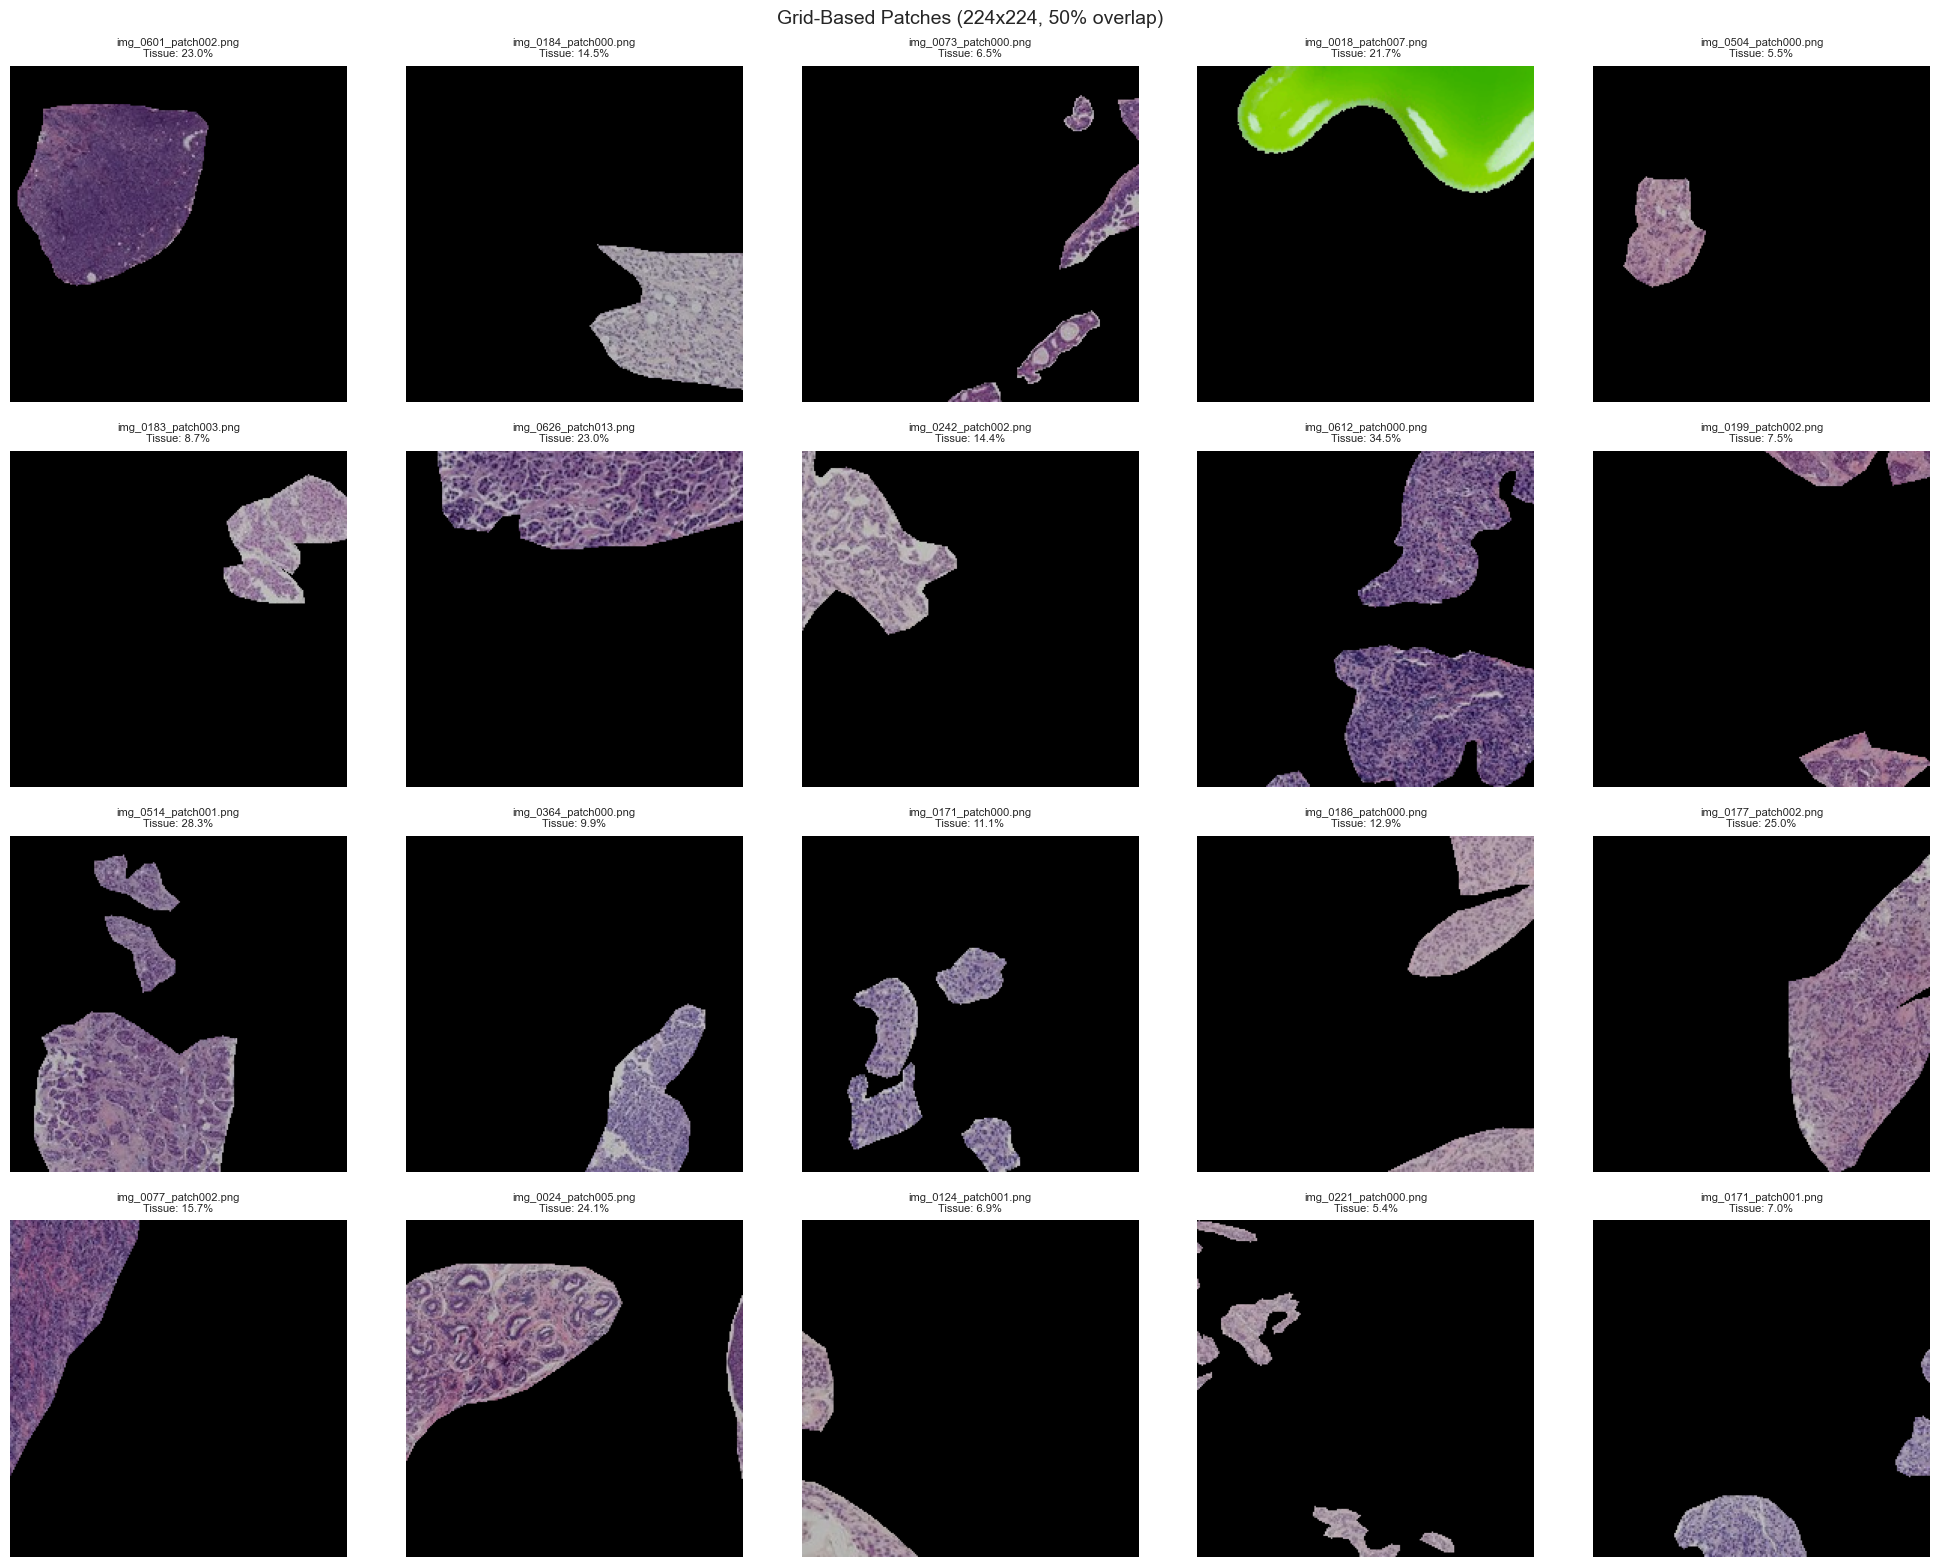

In [19]:
source_dir = Path(SOURCE_FOLDER)

# Create folder for grid-based patches
patched_output_dir = source_dir.parent / "train_data_patched_grid"

# CLEAR THE DIRECTORY FIRST
if patched_output_dir.exists():
    print(f"Clearing existing patches in {patched_output_dir}...")
    import shutil
    shutil.rmtree(patched_output_dir)
    
patched_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Source directory: {source_dir}")
print(f"Output directory for grid patches: {patched_output_dir}")

# Compute kept indices after eliminating the shrek images
all_indices = set(range(len(os.listdir(MASKED_IMAGE_PATH))))
kept_indices = sorted(list(all_indices - set(indx_eliminated)))

# Create grid patches with 20% overlap and 5% minimum tissue content
df_patches = create_grid_patched_dataset(
    source_dir=source_dir,
    output_dir=patched_output_dir,
    patch_size=224,
    overlap=0.0,  # 0% overlap between adjacent patches
    min_tissue_ratio=0.05,  # Keep patches with at least 5% tissue
    kept_indices=kept_indices  # Only process non-eliminated images
)

# Visualize some patches
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"\nTotal patches created: {len(patch_files)}")

# Show random samples
if len(patch_files) > 0:
    num_samples = min(20, len(patch_files))
    sample_indices = np.random.choice(len(patch_files), num_samples, replace=False)
    
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        patch_img = cv2.imread(str(patch_files[idx]))
        if patch_img is not None:
            patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB)
            
            # Calculate tissue content
            non_black = np.sum(patch_rgb.sum(axis=2) > 30)
            tissue_pct = (non_black / (224*224)) * 100
            
            axes[i].imshow(patch_rgb)
            axes[i].set_title(f"{patch_files[idx].name}\nTissue: {tissue_pct:.1f}%", fontsize=8)
            axes[i].axis('off')
    
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle("Grid-Based Patches (224x224, 50% overlap)", fontsize=14)
    plt.tight_layout()
    plt.show()

### **Green patched images filtering**

In [20]:
# Apply HSV filtering to the patches as well
print(f"\nApplying HSV filtering to patches in {patched_output_dir}...")

patch_files = sorted(list(patched_output_dir.glob("*.png")))

for patch_path in tqdm(patch_files, desc="Filtering patches"):
    patch_img = cv2.imread(str(patch_path))
    if patch_img is None:
        tqdm.write(f"Error: Could not load patch {patch_path}")
        continue
    
    # Convert from BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
    
    # Apply the filtering
    filtered_bgr, _ = filter_bright_green_areas(patch_rgb)
    
    # Convert back to BGR for saving
    filtered_bgr_save = filtered_bgr
    
    # Save the filtered patch back
    cv2.imwrite(str(patch_path), filtered_bgr_save)


Applying HSV filtering to patches in C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_data_patched_grid...


Filtering patches:   0%|          | 0/1678 [00:00<?, ?it/s]

Filtering patches: 100%|██████████| 1678/1678 [00:17<00:00, 97.99it/s] 


In [21]:
def filter_black_ratio(patch_dir, threshold_black_ratio=0.90, black_thr=20):
    """
    Removes patches where more than `threshold_black_ratio`
    of pixels are black/dark.

    threshold_black_ratio: float between 0 and 1.
    black_thr: RGB cutoff to consider a pixel 'black'.
    """
    patch_dir = Path(patch_dir)
    patch_files = sorted(list(patch_dir.glob("*.png")))

    kept_files = []
    removed_files = []
    
    for patch_file in patch_files:
        img = np.array(Image.open(patch_file))
        
        # Compute black mask
        black_mask = (
            (img[:,:,0] < black_thr) &
            (img[:,:,1] < black_thr) &
            (img[:,:,2] < black_thr)
        )

        black_ratio = black_mask.mean()   # fraction of black pixels
        
        if black_ratio > threshold_black_ratio:
            removed_files.append((patch_file, black_ratio))
            patch_file.unlink()  # delete file
        else:
            kept_files.append((patch_file, black_ratio))
    
    print("\nFiltering complete.")
    print(f"Total patches: {len(patch_files)}")
    print(f"Removed patches: {len(removed_files)}")
    print(f"Remaining patches: {len(kept_files)}")

    if removed_files:
        print("\nSome removed patch stats:")
        for f, r in removed_files[:10]:
            print(f"  {f.name}: black_ratio={r:.3f}")

    return kept_files, removed_files


In [22]:
kept, removed = filter_black_ratio(
    patched_output_dir,
    threshold_black_ratio=0.99,  # allow up to 99% black pixels
    black_thr=20                 # pixel considered "black" if < 20
)


Filtering complete.
Total patches: 1678
Removed patches: 153
Remaining patches: 1525

Some removed patch stats:
  img_0001_patch001.png: black_ratio=1.000
  img_0001_patch002.png: black_ratio=1.000
  img_0001_patch003.png: black_ratio=1.000
  img_0001_patch004.png: black_ratio=1.000
  img_0012_patch000.png: black_ratio=1.000
  img_0012_patch002.png: black_ratio=1.000
  img_0012_patch003.png: black_ratio=1.000
  img_0018_patch003.png: black_ratio=1.000
  img_0018_patch007.png: black_ratio=1.000
  img_0018_patch008.png: black_ratio=1.000



Removed Patches Analysis

Total removed patches: 153

Black ratio statistics for removed patches:
  Min black ratio: 0.991
  Max black ratio: 1.000
  Mean black ratio: 1.000
  Median black ratio: 1.000

First 20 removed patches:
  img_0001_patch001.png: black_ratio=1.000
  img_0001_patch002.png: black_ratio=1.000
  img_0001_patch003.png: black_ratio=1.000
  img_0001_patch004.png: black_ratio=1.000
  img_0012_patch000.png: black_ratio=1.000
  img_0012_patch002.png: black_ratio=1.000
  img_0012_patch003.png: black_ratio=1.000
  img_0018_patch003.png: black_ratio=1.000
  img_0018_patch007.png: black_ratio=1.000
  img_0018_patch008.png: black_ratio=1.000
  img_0020_patch001.png: black_ratio=1.000
  img_0020_patch002.png: black_ratio=1.000
  img_0020_patch003.png: black_ratio=1.000
  img_0020_patch004.png: black_ratio=1.000
  img_0028_patch000.png: black_ratio=1.000
  img_0028_patch001.png: black_ratio=1.000
  img_0028_patch002.png: black_ratio=1.000
  img_0028_patch003.png: black_ratio=1.

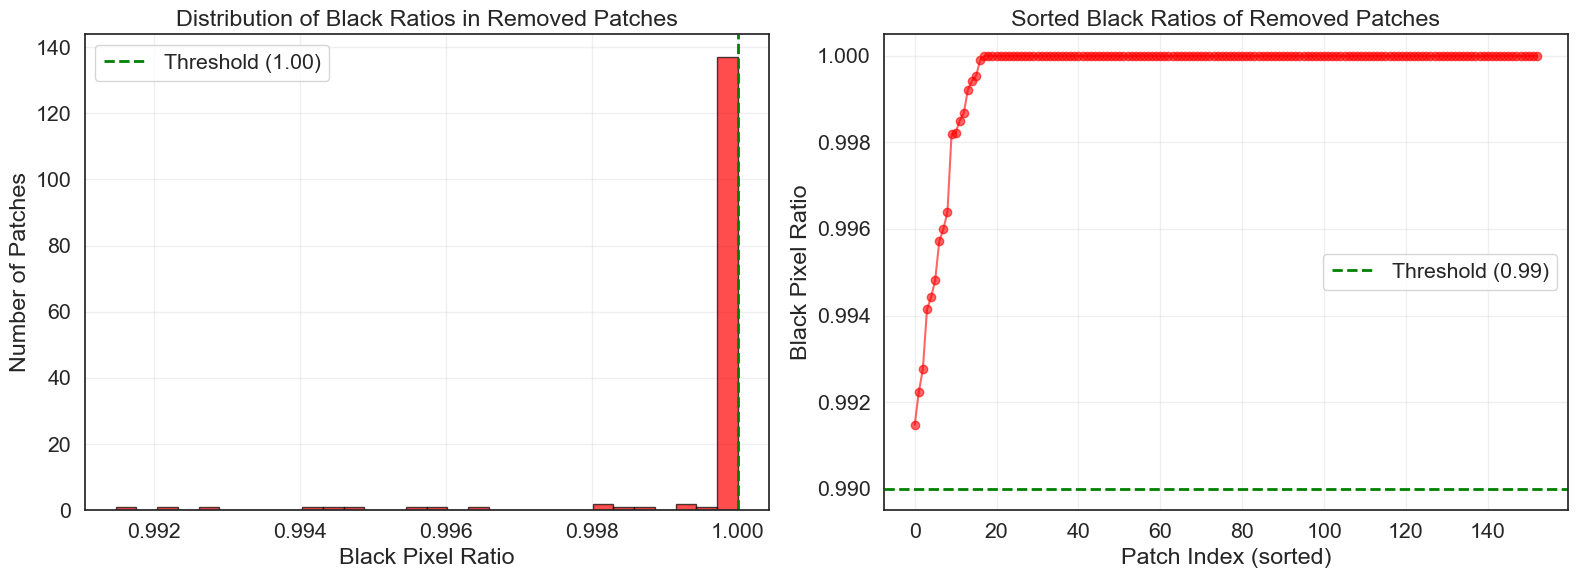

In [180]:
# Visualize statistics about removed patches (files already deleted)
print(f"\n{'='*60}")
print(f"Removed Patches Analysis")
print(f"{'='*60}")

if len(removed) > 0:
    # Extract filenames and black ratios
    removed_names = [f.name for f, _ in removed]
    removed_ratios = [ratio for _, ratio in removed]
    
    print(f"\nTotal removed patches: {len(removed)}")
    print(f"\nBlack ratio statistics for removed patches:")
    print(f"  Min black ratio: {min(removed_ratios):.3f}")
    print(f"  Max black ratio: {max(removed_ratios):.3f}")
    print(f"  Mean black ratio: {np.mean(removed_ratios):.3f}")
    print(f"  Median black ratio: {np.median(removed_ratios):.3f}")
    
    # Show first 20 removed patch names
    num_to_show = min(20, len(removed))
    print(f"\nFirst {num_to_show} removed patches:")
    for i in range(num_to_show):
        patch_file, black_ratio = removed[i]
        print(f"  {patch_file.name}: black_ratio={black_ratio:.3f}")
    
    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram of black ratios
    axes[0].hist(removed_ratios, bins=30, color='red', alpha=0.7, edgecolor='black')
    axes[0].axvline(1.0, color='green', linestyle='--', linewidth=2, label='Threshold (1.00)')
    axes[0].set_xlabel('Black Pixel Ratio')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Distribution of Black Ratios in Removed Patches')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Sorted black ratios
    sorted_ratios = sorted(removed_ratios)
    axes[1].plot(range(len(sorted_ratios)), sorted_ratios, 'o-', color='red', alpha=0.6)
    axes[1].axhline(0.99, color='green', linestyle='--', linewidth=2, label='Threshold (0.99)')
    axes[1].set_xlabel('Patch Index (sorted)')
    axes[1].set_ylabel('Black Pixel Ratio')
    axes[1].set_title('Sorted Black Ratios of Removed Patches')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo patches were removed.")

### **Splitting the dataset**


Creating Patch-to-Label Mapping CSV

Original labels CSV contains 691 entries
Created mapping for 691 original images
Found 1525 patch files in train_data_patched_grid


Mapping patches to labels: 100%|██████████| 1525/1525 [00:00<00:00, 517962.07it/s]


Mapping Results
Successfully labeled patches: 1525
Unlabeled patches: 0
Total patches: 1525

Saved patch labels to: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\an2dl2526c2\train_labels_patched.csv

Sample of patched labels CSV:
                filename  original_img_number            label
0  img_0000_patch000.png                    0  Triple negative
1  img_0001_patch000.png                    1        Luminal B
2  img_0002_patch000.png                    2        Luminal B
3  img_0003_patch000.png                    3        Luminal B
4  img_0003_patch001.png                    3        Luminal B
5  img_0003_patch002.png                    3        Luminal B
6  img_0003_patch003.png                    3        Luminal B
7  img_0004_patch000.png                    4        Luminal B
8  img_0004_patch001.png                    4        Luminal B
9  img_0006_patch000.png                    6        Luminal A

Label Distribution Across Patches
  HER2(+): 362 

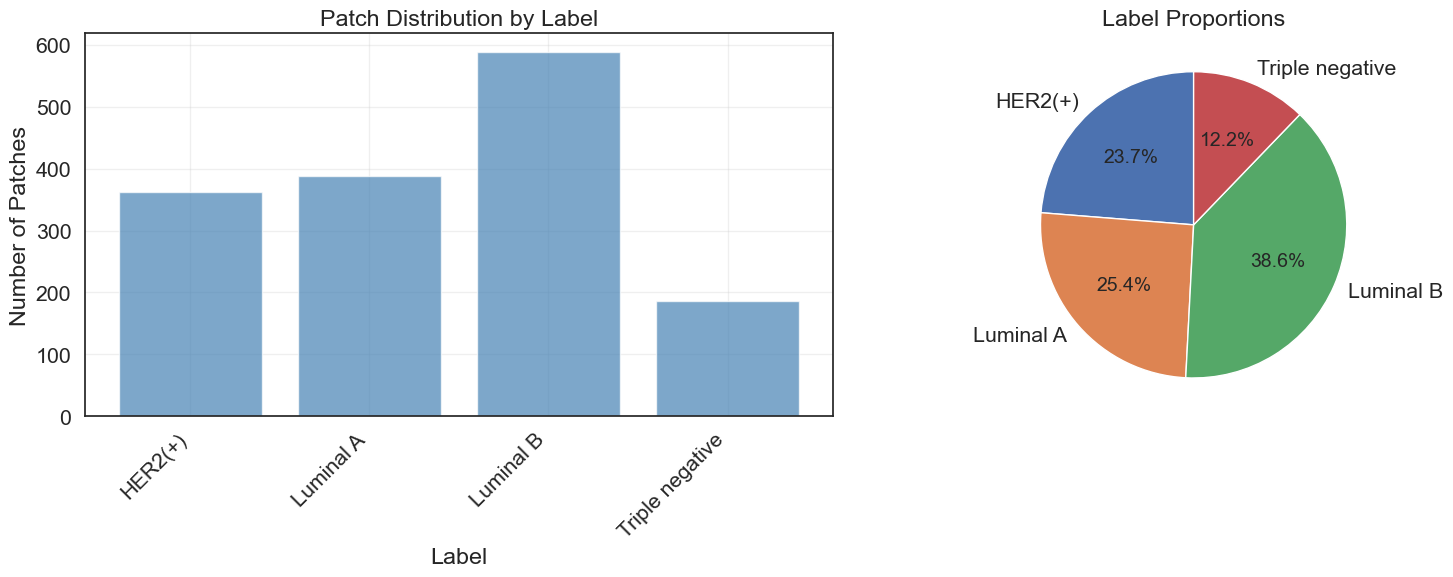


Patches Per Original Image Statistics
  Number of original images with patches: 517
  Min patches per image: 1
  Max patches per image: 18
  Mean patches per image: 2.95
  Median patches per image: 2


In [181]:
# Create a new CSV file mapping patches to labels based on original image indices
from typing import Counter

print(f"\n{'='*60}")
print(f"Creating Patch-to-Label Mapping CSV")
print(f"{'='*60}")

# Load original labels
original_labels_df = pd.read_csv(CSV_PATH)
print(f"\nOriginal labels CSV contains {len(original_labels_df)} entries")

# Create a mapping dictionary: image_number -> label
# The CSV format is: img_XXXX.jpg, label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0]  # e.g., "img_0042.jpg"
    label = row.iloc[1]      # e.g., "Tomato___Late_blight"
    
    # Extract the image number from filename
    # "img_0042.jpg" -> 42
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Get all patch files from the patched directory
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} patch files in {patched_output_dir.name}")

# Create lists to store patch data
patch_data = []
labeled_count = 0
unlabeled_count = 0
label_distribution = Counter()

# Process each patch file
for patch_file in tqdm(patch_files, desc="Mapping patches to labels"):
    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    filename = patch_file.stem  # Remove .png -> "img_0042_patch03"
    parts = filename.split('_')
    
    if len(parts) >= 3:
        try:
            # Extract the image number (e.g., "0042" -> 42)
            original_img_number = int(parts[1])
            patch_number = parts[2]  # e.g., "patch03"
            
            # Look up the label for this original image
            if original_img_number in image_to_label:
                label = image_to_label[original_img_number]
                
                # Store patch filename and label
                patch_data.append({
                    'filename': patch_file.name,  # e.g., "img_0042_patch03.png"
                    'original_img_number': original_img_number,
                    'label': label
                })
                
                labeled_count += 1
                label_distribution[label] += 1
            else:
                unlabeled_count += 1
                tqdm.write(f"Warning: No label found for image number {original_img_number}")
        except (ValueError, IndexError) as e:
            tqdm.write(f"Warning: Could not parse filename {patch_file.name}: {e}")
            unlabeled_count += 1
    else:
        tqdm.write(f"Warning: Unexpected filename format: {patch_file.name}")
        unlabeled_count += 1

# Create DataFrame from patch data
patches_df = pd.DataFrame(patch_data)

print(f"\n{'='*60}")
print(f"Mapping Results")
print(f"{'='*60}")
print(f"Successfully labeled patches: {labeled_count}")
print(f"Unlabeled patches: {unlabeled_count}")
print(f"Total patches: {len(patch_files)}")

if labeled_count > 0:
    # Save to new CSV file
    patches_csv_path = datasets_path / "train_labels_patched.csv"
    patches_df.to_csv(patches_csv_path, index=False)
    print(f"\nSaved patch labels to: {patches_csv_path}")
    
    # Display sample of the CSV
    print(f"\nSample of patched labels CSV:")
    print(patches_df.head(10))
    
    # Show label distribution
    print(f"\n{'='*60}")
    print(f"Label Distribution Across Patches")
    print(f"{'='*60}")
    for label, count in sorted(label_distribution.items()):
        percentage = (count / labeled_count) * 100
        print(f"  {label}: {count} patches ({percentage:.2f}%)")
    
    # Visualize label distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar chart
    labels_sorted = sorted(label_distribution.keys())
    counts_sorted = [label_distribution[l] for l in labels_sorted]
    
    axes[0].bar(range(len(labels_sorted)), counts_sorted, color='steelblue', alpha=0.7)
    axes[0].set_xticks(range(len(labels_sorted)))
    axes[0].set_xticklabels(labels_sorted, rotation=45, ha='right')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Number of Patches')
    axes[0].set_title('Patch Distribution by Label')
    axes[0].grid(True, alpha=0.3)
    
    # Pie chart
    axes[1].pie(counts_sorted, labels=labels_sorted, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Label Proportions')
    
    plt.tight_layout()
    plt.show()
    
    # Show patches per original image statistics
    patches_per_image = patches_df.groupby('original_img_number').size()
    print(f"\n{'='*60}")
    print(f"Patches Per Original Image Statistics")
    print(f"{'='*60}")
    print(f"  Number of original images with patches: {len(patches_per_image)}")
    print(f"  Min patches per image: {patches_per_image.min()}")
    print(f"  Max patches per image: {patches_per_image.max()}")
    print(f"  Mean patches per image: {patches_per_image.mean():.2f}")
    print(f"  Median patches per image: {patches_per_image.median():.0f}")
    
else:
    print("\nError: No patches were successfully labeled!")


Aligning Patched Images with Labels (Split by Original Images)

Loaded 691 original image labels from CSV
Created mapping for 691 original images
Loaded 1525 patch-label mappings

Splitting Original Images (to prevent data leakage)
Number of original images with patches: 517

Original image split:
  Training images: 361
  Validation images: 140
  Test images: 16

Assigning Patches to Splits
Found 1525 total patch files


Loading and splitting patches: 100%|██████████| 1525/1525 [00:01<00:00, 1430.01it/s]



Split Results
Skipped patches: 0
Total patches loaded: 1525

Label Encoding
Number of unique classes: 4
Classes: [np.str_('HER2(+)'), np.str_('Luminal A'), np.str_('Luminal B'), np.str_('Triple negative')]

Dataset Statistics

Training set:
  Images: (1022, 224, 224, 3)
  Labels: (1022,)
  Patches per original image (avg): 2.83
  Class distribution: [245 262 384 131]

Validation set:
  Images: (424, 224, 224, 3)
  Labels: (424,)
  Patches per original image (avg): 3.03
  Class distribution: [ 98 108 170  48]

Test set:
  Images: (79, 224, 224, 3)
  Labels: (79,)
  Patches per original image (avg): 4.94
  Class distribution: [19 18 35  7]

Class Distribution Across Splits

HER2(+) (class 0):
  Train: 245 (67.7%)
  Val:   98 (27.1%)
  Test:  19 (5.2%)

Luminal A (class 1):
  Train: 262 (67.5%)
  Val:   108 (27.8%)
  Test:  18 (4.6%)

Luminal B (class 2):
  Train: 384 (65.2%)
  Val:   170 (28.9%)
  Test:  35 (5.9%)

Triple negative (class 3):
  Train: 131 (70.4%)
  Val:   48 (25.8%)
  Te

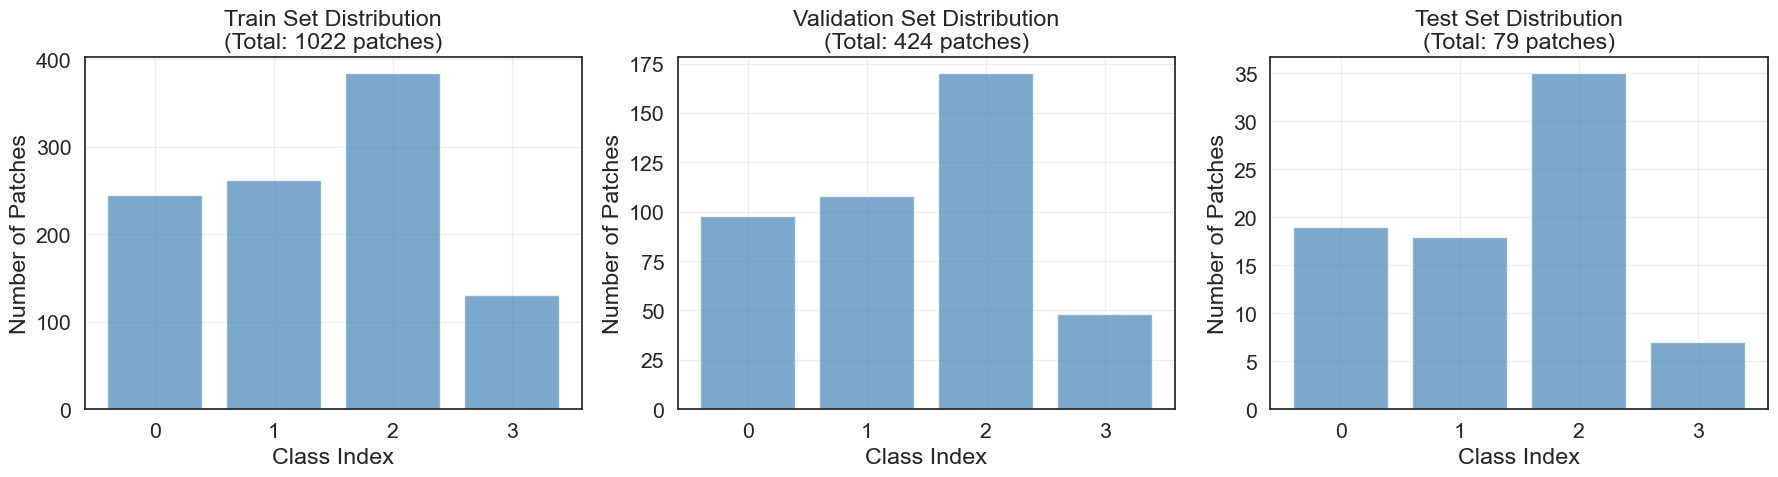


Dataset preparation complete!
No data leakage: Each original image's patches are in only ONE split


In [182]:
from sklearn.preprocessing import LabelEncoder

print(f"\n{'='*60}")
print(f"Aligning Patched Images with Labels (Split by Original Images)")
print(f"{'='*60}")

# Load the ORIGINAL labels CSV (not the patched one)
original_csv_path = datasets_path / "train_labels.csv"
if not original_csv_path.exists():
    raise FileNotFoundError(f"Original labels CSV not found at {original_csv_path}")

original_labels_df = pd.read_csv(original_csv_path)
print(f"\nLoaded {len(original_labels_df)} original image labels from CSV")

# Create mapping: image_number -> label
image_to_label = {}
for idx, row in original_labels_df.iterrows():
    filename = row.iloc[0] 
    label = row.iloc[1]      
    img_number = int(filename.split('_')[1].split('.')[0])
    image_to_label[img_number] = label

print(f"Created mapping for {len(image_to_label)} original images")

# Load the patched labels CSV to get all patches
patches_csv_path = datasets_path / "train_labels_patched.csv"
if not patches_csv_path.exists():
    raise FileNotFoundError(f"Patched labels CSV not found at {patches_csv_path}")

patches_df = pd.read_csv(patches_csv_path)
print(f"Loaded {len(patches_df)} patch-label mappings")

# STEP 1: Split at the ORIGINAL IMAGE LEVEL
print(f"\n{'='*60}")
print(f"Splitting Original Images (to prevent data leakage)")
print(f"{'='*60}")

# Get unique original image numbers that have patches
original_img_numbers = patches_df['original_img_number'].unique()
print(f"Number of original images with patches: {len(original_img_numbers)}")

# Get labels for these images
original_labels = [image_to_label[img_num] for img_num in original_img_numbers]

# Encode labels for stratification
label_encoder = LabelEncoder()
original_labels_encoded = label_encoder.fit_transform(original_labels)

# Split original images into train/temp (80/20)
train_img_nums, temp_img_nums, train_img_labels, temp_img_labels = train_test_split(
    original_img_numbers,
    original_labels_encoded,
    test_size=0.3,
    random_state=SEED,
    stratify=original_labels_encoded
)

# Split temp into val/test (50/50 of temp = 10/10 of total)
val_img_nums, test_img_nums, val_img_labels, test_img_labels = train_test_split(
    temp_img_nums,
    temp_img_labels,
    test_size=0.1,
    random_state=SEED,
    stratify=temp_img_labels
)

print(f"\nOriginal image split:")
print(f"  Training images: {len(train_img_nums)}")
print(f"  Validation images: {len(val_img_nums)}")
print(f"  Test images: {len(test_img_nums)}")

# STEP 2: Assign patches to splits based on their original image
print(f"\n{'='*60}")
print(f"Assigning Patches to Splits")
print(f"{'='*60}")

train_img_set = set(train_img_nums)
val_img_set = set(val_img_nums)
test_img_set = set(test_img_nums)

# Get all patch files
patch_files = sorted(list(patched_output_dir.glob("*.png")))
print(f"Found {len(patch_files)} total patch files")

# Create a dictionary for fast lookup: filename -> label
patch_to_label = dict(zip(patches_df['filename'], patches_df['label']))

# Separate patches into train/val/test based on original image
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

skipped_count = 0

for patch_file in tqdm(patch_files, desc="Loading and splitting patches"):
    patch_filename = patch_file.name
    
    # Extract original image number from patch filename
    # Format: img_0042_patch03.png
    parts = patch_filename.split('_')
    if len(parts) < 3:
        skipped_count += 1
        continue
    
    try:
        original_img_number = int(parts[1])
    except ValueError:
        skipped_count += 1
        continue
    
    # Look up the label
    if patch_filename not in patch_to_label:
        skipped_count += 1
        continue
    
    label = patch_to_label[patch_filename]
    
    # Load the patch image
    patch_img = cv2.imread(str(patch_file))
    if patch_img is None:
        tqdm.write(f"Warning: Could not load {patch_filename}")
        skipped_count += 1
        continue
    
    # Convert BGR to RGB and normalize to [0, 1]
    patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
    
    # Assign to appropriate split based on original image number
    if original_img_number in train_img_set:
        X_train_list.append(patch_rgb)
        y_train_list.append(label)
    elif original_img_number in val_img_set:
        X_val_list.append(patch_rgb)
        y_val_list.append(label)
    elif original_img_number in test_img_set:
        X_test_list.append(patch_rgb)
        y_test_list.append(label)
    else:
        skipped_count += 1

# Convert to numpy arrays
X_train = np.array(X_train_list)
y_train = np.array(y_train_list)
X_val = np.array(X_val_list)
y_val = np.array(y_val_list)
X_test = np.array(X_test_list)
y_test = np.array(y_test_list)

print(f"\n{'='*60}")
print(f"Split Results")
print(f"{'='*60}")
print(f"Skipped patches: {skipped_count}")
print(f"Total patches loaded: {len(X_train) + len(X_val) + len(X_test)}")

# Encode labels
y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Print class mapping
print(f"\n{'='*60}")
print(f"Label Encoding")
print(f"{'='*60}")
print(f"Number of unique classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

# Show split statistics
print(f"\n{'='*60}")
print(f"Dataset Statistics")
print(f"{'='*60}")

print(f"\nTraining set:")
print(f"  Images: {X_train.shape}")
print(f"  Labels: {y_train_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_train) / len(train_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_train_encoded)}")

print(f"\nValidation set:")
print(f"  Images: {X_val.shape}")
print(f"  Labels: {y_val_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_val) / len(val_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_val_encoded)}")

print(f"\nTest set:")
print(f"  Images: {X_test.shape}")
print(f"  Labels: {y_test_encoded.shape}")
print(f"  Patches per original image (avg): {len(X_test) / len(test_img_nums):.2f}")
print(f"  Class distribution: {np.bincount(y_test_encoded)}")

# Show label distribution across splits
unique_train, counts_train = np.unique(y_train_encoded, return_counts=True)
unique_val, counts_val = np.unique(y_val_encoded, return_counts=True)
unique_test, counts_test = np.unique(y_test_encoded, return_counts=True)

print(f"\n{'='*60}")
print(f"Class Distribution Across Splits")
print(f"{'='*60}")
for class_idx in range(len(label_encoder.classes_)):
    class_name = label_encoder.classes_[class_idx]
    train_count = counts_train[class_idx] if class_idx in unique_train else 0
    val_count = counts_val[class_idx] if class_idx in unique_val else 0
    test_count = counts_test[class_idx] if class_idx in unique_test else 0
    total = train_count + val_count + test_count
    
    print(f"\n{class_name} (class {class_idx}):")
    print(f"  Train: {train_count} ({train_count/total*100:.1f}%)")
    print(f"  Val:   {val_count} ({val_count/total*100:.1f}%)")
    print(f"  Test:  {test_count} ({test_count/total*100:.1f}%)")

# Visualize split distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (split_name, split_labels) in enumerate([
    ('Train', y_train_encoded), 
    ('Validation', y_val_encoded), 
    ('Test', y_test_encoded)
]):
    class_counts = np.bincount(split_labels)
    axes[idx].bar(range(len(class_counts)), class_counts, color='steelblue', alpha=0.7)
    axes[idx].set_xlabel('Class Index')
    axes[idx].set_ylabel('Number of Patches')
    axes[idx].set_title(f'{split_name} Set Distribution\n(Total: {len(split_labels)} patches)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update the global variables to use encoded labels
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

print(f"\n{'='*60}")
print(f"Dataset preparation complete!")
print(f"No data leakage: Each original image's patches are in only ONE split")
print(f"{'='*60}")

## 4. **Training**

In [183]:
# Define the input shape based on the training data
input_shape = (X_train.shape[3], X_train.shape[1], X_train.shape[2])

# Define the number of classes
num_classes = len(np.unique(y_train))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 224, 224)
Number of Classes: 4


In [184]:
# Convert numpy arrays to PyTorch datasets (without augmentation for now)
train_ds = TensorDataset(
    torch.from_numpy(X_train).permute(0, 3, 1, 2),
    torch.from_numpy(y_train).squeeze().long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).permute(0, 3, 1, 2),
    torch.from_numpy(y_val).squeeze().long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test).permute(0, 3, 1, 2),
    torch.from_numpy(y_test).squeeze().long()
)

In [185]:
# Define the batch size
BATCH_SIZE = 32

In [186]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset augmentation and normalization."""

    def __init__(self, data, labels, augmentation=None, normalize_imagenet=False):
        """
        Args:
            data: numpy array of images (N, H, W, C) in range [0, 1]
            labels: numpy array of labels
            augmentation: transforms for data augmentation
            normalize_imagenet: whether to apply ImageNet normalization
        """
        # Convert from (N, H, W, C) to (N, C, H, W) for PyTorch
        # IMPORTANT: Use .float() to ensure float32 type (compatible with mixed precision)
        self.data = torch.from_numpy(data).permute(0, 3, 1, 2).float()
        self.labels = torch.from_numpy(labels).long()
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet

        # ImageNet normalization transform
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].clone()  # Clone to avoid modifying original (already in C, H, W format)
        label = self.labels[idx]

        # Apply augmentation if provided (on images in [0, 1] range)
        if self.augmentation:
            image = self.augmentation(image)

        # Apply ImageNet normalization if requested
        if self.normalize:
            image = self.normalize(image)

        return image, label

In [187]:
def make_loader(ds, batch_size, shuffle, drop_last):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch
        drop_last (bool): Whether to drop last incomplete batch

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Use 0 workers on Windows to avoid multiprocessing issues
    # Single-threaded loading is more stable on Windows
    num_workers = 0

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
    )

###  🧮 **Network Parameters**

In [188]:
# Training parameters
LEARNING_RATE = 3e-4
EPOCHS = 200
PATIENCE = 50

# Regularization
DROPOUT_RATE = 0.3
L2_REGULARIZATION = 1e-2

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# Set up loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rate:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("Patience:", PATIENCE)

Epochs: 200
Batch Size: 32
Learning Rate: 0.0003
Dropout Rate: 0.3
Patience: 50


###  🧠 **Training Functions**

In [189]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [190]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        use_amp = device.type == 'cuda' and scaler is not None
        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling (only if scaler is provided)
        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [191]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    all_targets_concat = np.concatenate(all_targets)
    all_predictions_concat = np.concatenate(all_predictions)
    
    epoch_f1 = f1_score(all_targets_concat, all_predictions_concat, average='weighted')
    epoch_precision = precision_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)
    epoch_recall = recall_score(all_targets_concat, all_predictions_concat, average='weighted', zero_division=0)

    return epoch_loss, epoch_f1, epoch_precision, epoch_recall

In [192]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name="", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

# NOTE: Graphviz visualization commented out - requires Graphviz installation



# model_graph.visual_graph# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)# After installing Graphviz, restart kernel and uncomment these lines:        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': []
    }

    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        train_loss, train_f1, train_precision, train_recall = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device
        )

        val_loss, val_f1, val_precision, val_recall = validate_one_epoch(
            model, val_loader, criterion, device
        )

        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_acc'].append(train_f1)  # For backward compatibility
        training_history['val_acc'].append(val_f1)  # For backward compatibility
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)
        training_history['train_precision'].append(train_precision)
        training_history['val_precision'].append(val_precision)
        training_history['train_recall'].append(train_recall)
        training_history['val_recall'].append(val_recall)

        if writer is not None:
            writer.add_scalar('Loss/Training', train_loss, epoch)
            writer.add_scalar('Loss/Validation', val_loss, epoch)
            writer.add_scalar('F1/Training', train_f1, epoch)
            writer.add_scalar('F1/Validation', val_f1, epoch)
            writer.add_scalar('Precision/Training', train_precision, epoch)
            writer.add_scalar('Precision/Validation', val_precision, epoch)
            writer.add_scalar('Recall/Training', train_recall, epoch)
            writer.add_scalar('Recall/Validation', val_recall, epoch)

        if verbose and epoch % verbose == 0:
            print(f"Epoch {epoch:3d}/{epochs} | "
                  f"Train: Loss={train_loss:.4f}, F1={train_f1:.4f}, Prec={train_precision:.4f}, Rec={train_recall:.4f} | "
                  f"Val: Loss={val_loss:.4f}, F1={val_f1:.4f}, Prec={val_precision:.4f}, Rec={val_recall:.4f}")

        # Learning rate scheduling
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)  # Step based on validation F1
            else:
                scheduler.step()  # For other schedulers

        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                model_path = f"models/{experiment_name}_best_model.pt"
                torch.save(model.state_dict(), model_path)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break
                    
    if restore_best_weights and patience > 0:
        model_path = f"models/{experiment_name}_best_model.pt"
        model.load_state_dict(torch.load(model_path))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
    return model, training_history

###  🛠️ **Train from Scratch**

In [202]:
# Improved ResNet architecture with better classifier head
class ResNetFromScratch(nn.Module):
    """ResNet trained from scratch with improved classifier head."""

    def __init__(self, num_classes, dropout_rate=0.3):
        super().__init__()

        # Use ResNet18 but replace first conv to reduce parameters
        self.backbone = torchvision.models.resnet18(weights=None)
        
        # Remove the original fc layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Simpler classifier head (fewer layers, fewer neurons)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),  # 512 -> 256
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)  # Direct to output (removed intermediate layer)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [203]:
# Initialize model
scratch_model = ResNetFromScratch(num_classes, DROPOUT_RATE).to(device)

# Visualize structure
summary(scratch_model, input_size=input_shape)
# model_graph = draw_graph(scratch_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [195]:
# Print total parameters
total_params = sum(p.numel() for p in scratch_model.parameters())
trainable_params = sum(p.numel() for p in scratch_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 11,309,380
Trainable parameters: 11,309,380


Compute automated augmentation while training

In [196]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0, 
        # translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),
    
    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    # transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness
    
    # Occlusion simulation
    transforms.RandomErasing(
        p=0.3,  # Reduced probability for more balanced augmentation
        scale=(0.02, 0.15),  # Reduced max scale
        ratio=(0.3, 3.3)  # Aspect ratio range
    )
    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

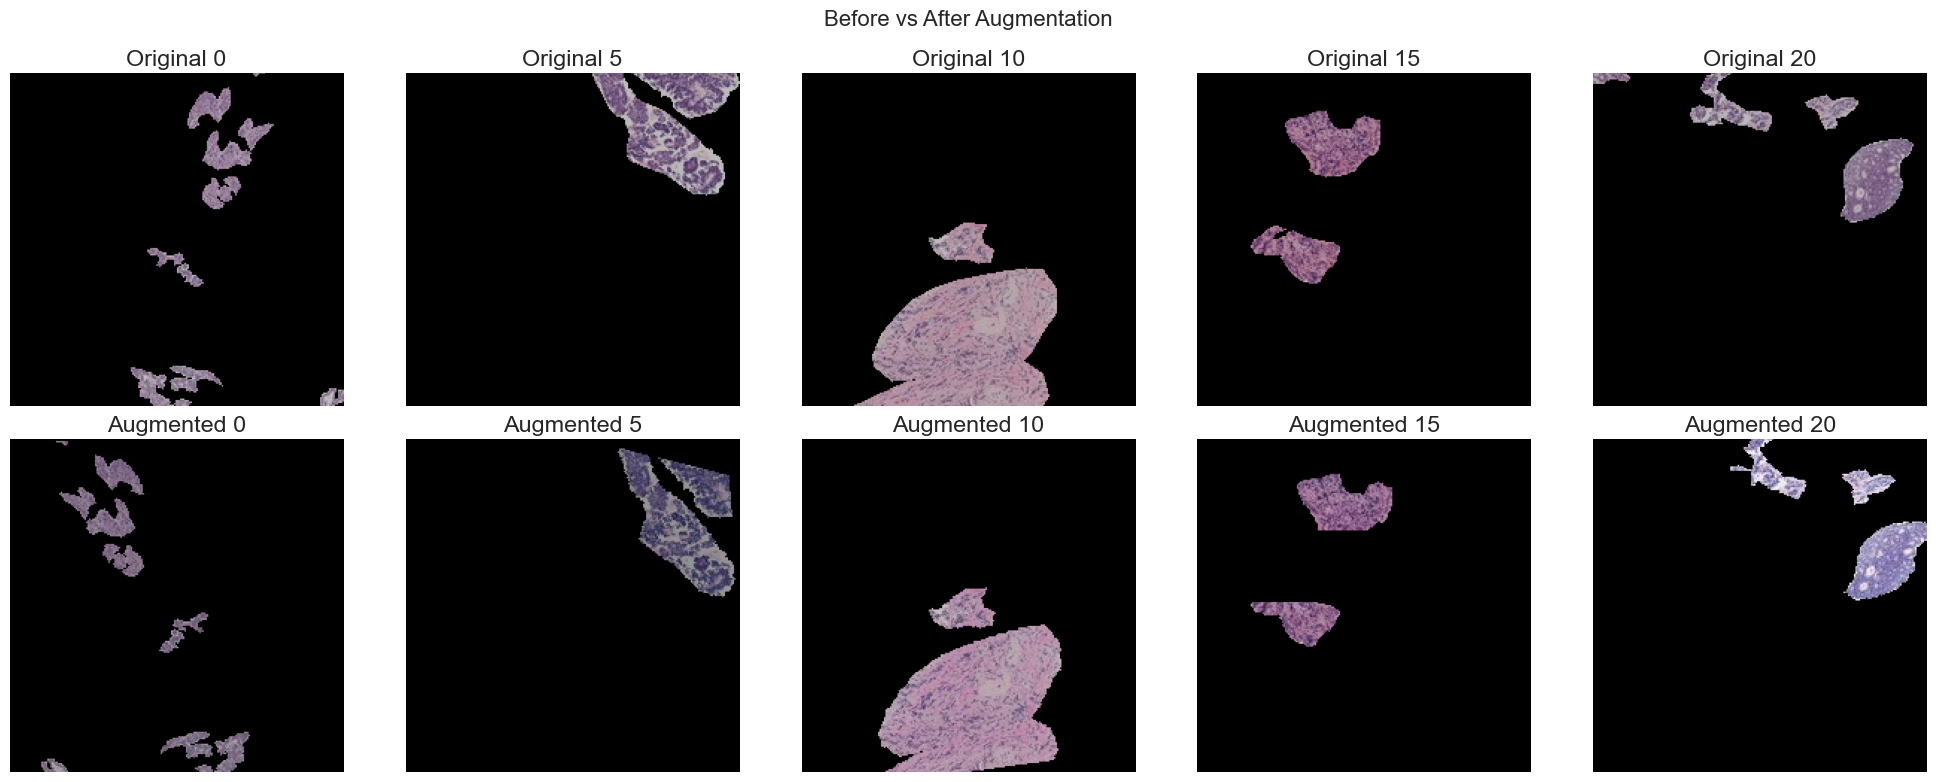


Multiple augmentations of the same image (showing randomness):


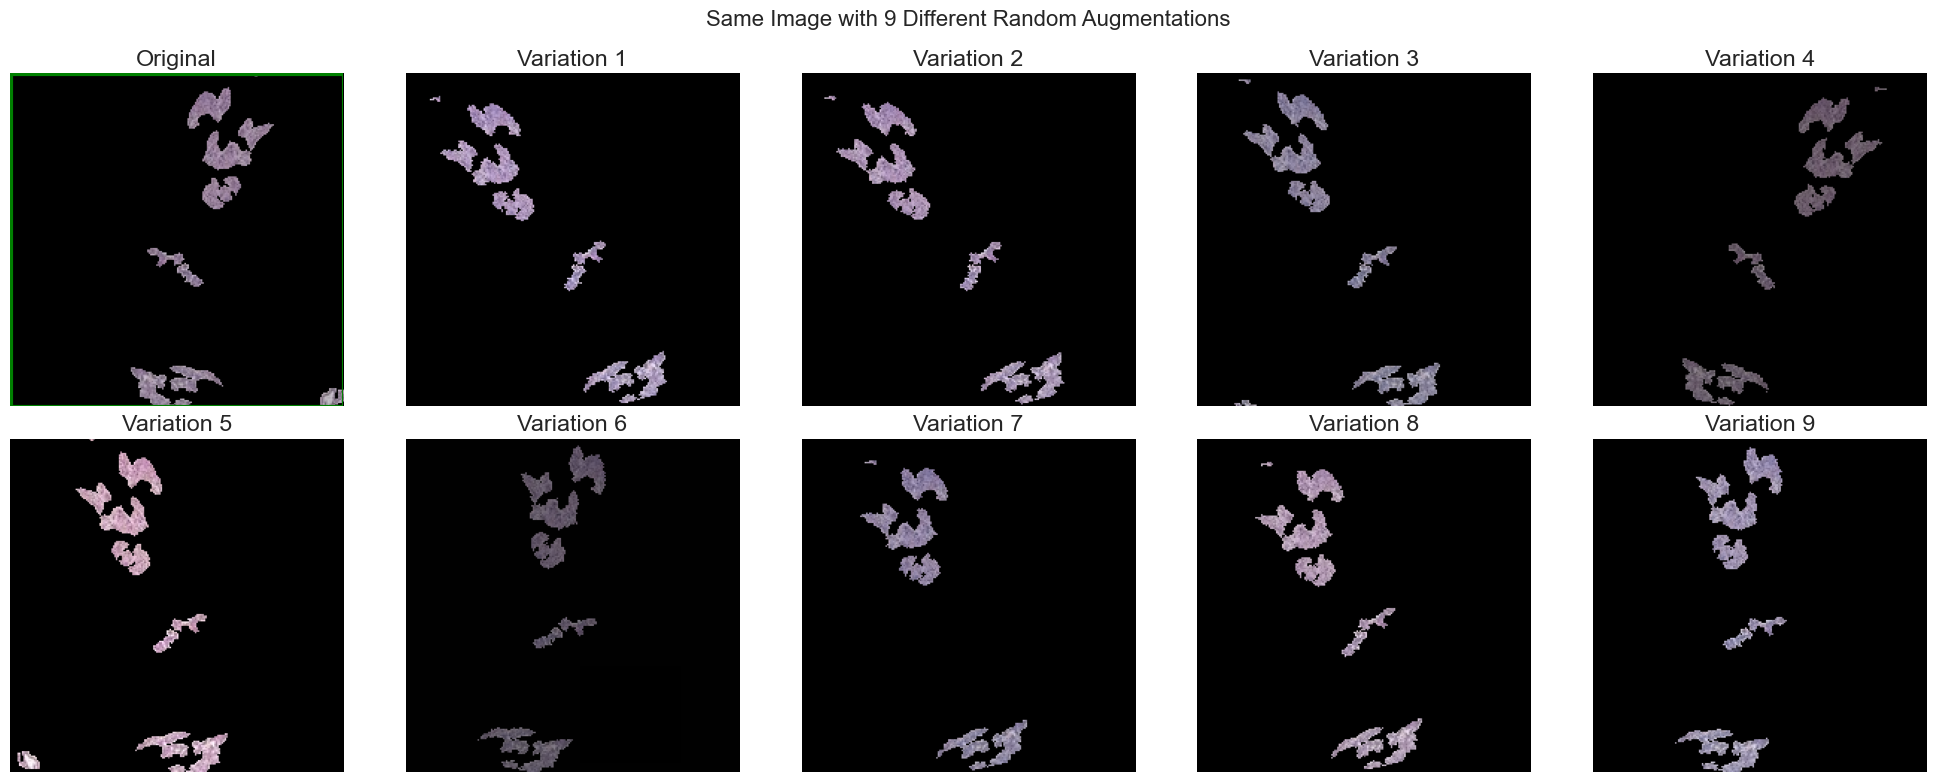

In [197]:
# Visualize augmentation effects by comparing original vs augmented images side-by-side
# This shows how RandomHorizontalFlip, RandomAffine, and RandomErasing transform the images

# Select a few sample images
num_samples = 5
sample_indices = [0, 5, 10, 15, 20]

# Create a grid: original on top row, augmented on bottom row
fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))

for col, idx in enumerate(sample_indices):
    # Original image
    original_img = X_train[idx]
    axes[0, col].imshow(np.clip(original_img, 0, 1))
    axes[0, col].set_title(f"Original {idx}")
    axes[0, col].axis('off')
    
    # Apply augmentation
    sample_tensor = torch.from_numpy(original_img).permute(2, 0, 1)  # Convert to C,H,W
    augmented_tensor = train_augmentation(sample_tensor)
    augmented_img = augmented_tensor.permute(1, 2, 0).numpy()  # Back to H,W,C
    
    axes[1, col].imshow(np.clip(augmented_img, 0, 1))
    axes[1, col].set_title(f"Augmented {idx}")
    axes[1, col].axis('off')

plt.suptitle("Before vs After Augmentation", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Show multiple augmented versions of the same image
print("\nMultiple augmentations of the same image (showing randomness):")
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

sample_idx = 0
sample_img = X_train[sample_idx]

# Show original once
axes[0, 0].imshow(np.clip(sample_img, 0, 1))
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')
axes[0, 0].add_patch(plt.Rectangle((0, 0), sample_img.shape[1], sample_img.shape[0], 
                                    fill=False, edgecolor='green', linewidth=3))

# Show 9 different augmented versions
for i in range(9):
    row = (i + 1) // 5
    col = (i + 1) % 5
    
    sample_tensor = torch.from_numpy(sample_img).permute(2, 0, 1)
    augmented_tensor = train_augmentation(sample_tensor)
    augmented_img = augmented_tensor.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(np.clip(augmented_img, 0, 1))
    axes[row, col].set_title(f"Variation {i+1}")
    axes[row, col].axis('off')

plt.suptitle(f"Same Image with 9 Different Random Augmentations", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [198]:
# Create datasets and dataloaders with augmentation for training set
train_scratch_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=False)
val_scratch_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=False)

train_scratch_loader = make_loader(train_scratch_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_scratch_loader = make_loader(val_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Check a sample batch
sample_batch, sample_labels = next(iter(train_scratch_loader))

# Validate data before training
print("\nData Validation:")
print(f"Train samples: {len(train_scratch_ds)}")
print(f"Val samples: {len(val_scratch_ds)}")
print(f"Batch shape: {sample_batch.shape}")
print(f"Batch value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"Labels in batch: {sample_labels[:10].tolist()}")
print(f"Number of classes: {num_classes}")
print(f"Class distribution in training: {np.bincount(y_train)}")


Data Validation:
Train samples: 1022
Val samples: 424
Batch shape: torch.Size([32, 3, 224, 224])
Batch value range: [0.000, 1.000]
Labels in batch: [0, 1, 1, 2, 2, 1, 1, 2, 2, 1]
Number of classes: 4
Class distribution in training: [245 262 384 131]


In [199]:
# Setup Training
experiment_name = "from_scratch"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# optimizer = torch.optim.Adam(scratch_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
optimizer = torch.optim.LBFGS(scratch_model.parameters(), lr=LEARNING_RATE)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

print(f"Experiment: {experiment_name}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay: 1e-4")
print(f"LR scheduler: ReduceLROnPlateau (patience=5)")
print(f"Early stopping patience: {PATIENCE}")

Experiment: from_scratch
Learning rate: 0.0003
Weight decay: 1e-4
LR scheduler: ReduceLROnPlateau (patience=5)
Early stopping patience: 50


In [ ]:
# Train improved model with all fixes
scratch_model, scratch_history = fit(
    model=scratch_model,
    train_loader=train_scratch_loader,
    val_loader=val_scratch_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l2_lambda=L2_REGULARIZATION,
    writer=writer,
    scheduler=scheduler,  # Added LR scheduling
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(scratch_history['val_f1']) * 100, 2)
final_train_f1 = round(max(scratch_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(scratch_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(scratch_history['val_loss'], label='Validation loss', alpha=0.9, color="#ff7e0e")
ax1.set_title('Categorical Crossentropy')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(scratch_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(scratch_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#ff7f0e')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

In [ ]:
# Enhanced training history visualization with all metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Loss plot
axes[0, 0].plot(scratch_history['train_loss'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 0].plot(scratch_history['val_loss'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# F1 Score plot
axes[0, 1].plot(scratch_history['train_f1'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[0, 1].plot(scratch_history['val_f1'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[0, 1].set_title('F1 Score over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision plot
axes[1, 0].plot(scratch_history['train_precision'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 0].plot(scratch_history['val_precision'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall plot
axes[1, 1].plot(scratch_history['train_recall'], label='Training', alpha=0.7, color='#1f77b4', linewidth=2)
axes[1, 1].plot(scratch_history['val_recall'], label='Validation', alpha=0.9, color='#ff7f0e', linewidth=2)
axes[1, 1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("Training Summary:")
print("="*60)
print(f"Best Training   - Loss: {min(scratch_history['train_loss']):.4f}, F1: {max(scratch_history['train_f1']):.4f}, "
      f"Prec: {max(scratch_history['train_precision']):.4f}, Rec: {max(scratch_history['train_recall']):.4f}")
print(f"Best Validation - Loss: {min(scratch_history['val_loss']):.4f}, F1: {max(scratch_history['val_f1']):.4f}, "
      f"Prec: {max(scratch_history['val_precision']):.4f}, Rec: {max(scratch_history['val_recall']):.4f}")
print("="*60)

In [ ]:
# Make predictions on the test set created inside the training set
test_scratch_ds = TissueDataset(X_test, y_test, augmentation=None, normalize_imagenet=False)
test_scratch_loader = make_loader(test_scratch_ds, BATCH_SIZE, shuffle=False, drop_last=False)

best_val_acc = max(scratch_history['val_acc'])
model_path = Path(f"models/{experiment_name}_{best_val_acc:.4f}_model.pt")
if not model_path.exists():
    candidates = sorted(Path("models").glob(f"{experiment_name}_*_model.pt"))
    if candidates:
        model_path = candidates[-1]
    else:
        raise FileNotFoundError(f"No model file matching {model_path.name}")
scratch_model.load_state_dict(torch.load(model_path, map_location=device))
scratch_model.eval()
print(f"Loaded weights from {model_path.name}")

all_test_predictions = []
with torch.no_grad():
    for inputs, _ in test_scratch_loader:
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = scratch_model(inputs)
        predictions = logits.argmax(dim=1)
        all_test_predictions.append(predictions.cpu().numpy())
all_test_predictions = np.concatenate(all_test_predictions)

# Calculate test metrics
test_f1 = f1_score(y_test, all_test_predictions, average='weighted')
test_precision = precision_score(y_test, all_test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(y_test, all_test_predictions, average='weighted', zero_division=0)
print(f"\nTest Set Performance:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

## 🛠️ **Transfer Learining**

In [204]:
class EfficientNetB1TransferLearning(nn.Module):
    """EfficientNet-B1 with ImageNet pretrained weights."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        # Load weights pretrained on ImageNet
        self.backbone = torchvision.models.efficientnet_b1(
            weights=torchvision.models.EfficientNet_B1_Weights.DEFAULT
        )

        # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # Replace classifier (Always trainable)
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
        )

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# MobileNetv3 small
class MobileNetV3Small(nn.Module):
    """MobileNetV3 Small architecture for image classification."""

    def __init__(self, num_classes, dropout_rate=0.2, freeze_backbone=True):
        super().__init__()

        # Load MobileNetV3 Small with pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
        )
             # Freeze the backbone layers (features)
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        # MobileNetV3 classifier structure is different:
        # classifier[0] is Linear(576 -> 1024)
        # classifier[1] is Hardswish
        # classifier[2] is Dropout
        # classifier[3] is Linear(1024 -> num_classes)

        # Get the correct input features from the last conv layer
        # For MobileNetV3-Small, the last feature size is 576
        in_features = 576  # This is the output from the last conv block


        # Replace the entire classifier head
        #self.backbone.classifier = nn.Sequential(
        #    nn.Linear(in_features, 1024),  # Match original architecture
        #    nn.Hardswish(inplace=True),
        #    nn.Dropout(p=dropout_rate),
        #    nn.Linear(1024, 256),
        #    nn.ReLU(inplace=True),
        #    nn.Dropout(p=dropout_rate),
        #    nn.Linear(256, num_classes)
        #)
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 512),  # Match original architecture
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, num_classes)
            # nn.Linear(512, num_classes)  # Added just this final layer for simplifying the architecture
        )


    def forward(self, x):
        return self.backbone(x)

In [53]:
# Transfer Learning approach - freeze most layers
class ResNetTransfer(nn.Module):
    """ResNet with pretrained weights and fine-tuning."""

    def __init__(self, num_classes, dropout_rate=0.3, freeze_layers=True):
        super().__init__()

        # Load PRETRAINED ResNet18
        self.backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        
        # Freeze early layers (train only last layers)
        if freeze_layers:
            # Freeze all layers except last residual block
            for name, param in self.backbone.named_parameters():
                if 'layer4' not in name and 'fc' not in name:
                    param.requires_grad = False
        
        # Replace classifier
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

# Initialize with transfer learning
scratch_model = ResNetTransfer(num_classes, DROPOUT_RATE, freeze_layers=True).to(device)

# Count trainable vs total parameters
total_params = sum(p.numel() for p in scratch_model.parameters())
trainable_params = sum(p.numel() for p in scratch_model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


Total parameters: 11,308,868
Trainable parameters: 8,526,084
Frozen parameters: 2,782,784


### **MobileNetV3 model**

Run one of the below model declaration

In [152]:
# Create transfer learning model
tl_model = MobileNetV3Small(num_classes, DROPOUT_RATE).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

### **ResNet model**

In [ ]:
# Create transfer learning model
tl_model = ResNetTransfer(num_classes, DROPOUT_RATE, freeze_layers=True).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

### **EfficientNetB0/B1/B2 model**

In [205]:
# Create transfer learning model
tl_model = EfficientNetB1TransferLearning(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# Display model summary
summary(tl_model, input_size=input_shape)
# model_graph = draw_graph(tl_model, input_size=(BATCH_SIZE,)+input_shape, expand_nested=True, depth=6)
# model_graph.visual_graph

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

### **Training the choosen model**

In [206]:
train_tl_ds = TissueDataset(X_train, y_train, augmentation=train_augmentation, normalize_imagenet=True)
val_tl_ds = TissueDataset(X_val, y_val, augmentation=None, normalize_imagenet=True)

train_tl_loader = make_loader(train_tl_ds, BATCH_SIZE, shuffle=True, drop_last=False)
val_tl_loader = make_loader(val_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

In [207]:
# Setup training for transfer learning (without mixed precision)
experiment_name = "transfer_learning"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)

# Create optimizer for transfer learning model
optimizer = torch.optim.RAdam(tl_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

print(f"Experiment: {experiment_name}")
print(f"Device: {device}")
print(f"Mixed precision: Disabled (scaler=None)")
print(f"Learning rate: {LEARNING_RATE}")

Experiment: transfer_learning
Device: cuda
Mixed precision: Disabled (scaler=None)
Learning rate: 0.0003


In [208]:
# Train with transfer learning (no mixed precision scaler)
tl_model, tl_history = fit(
    model=tl_model,
    train_loader=train_tl_loader,
    val_loader=val_tl_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=None,  # Disable mixed precision for transfer learning
    device=device,
    l2_lambda=L2_REGULARIZATION,
    writer=writer,
    scheduler=scheduler,
    verbose=5,
    experiment_name=experiment_name,
    patience=PATIENCE
)

final_val_f1 = round(max(tl_history['val_f1']) * 100, 2)
final_train_f1 = round(max(tl_history['train_f1']) * 100, 2)
print(f'\n{"="*60}')
print(f'Training Complete!')
print(f'Best Training F1: {final_train_f1}%')
print(f'Best Validation F1: {final_val_f1}%')
print(f'{"="*60}')

Training 200 epochs...
Epoch   5/200 | Train: Loss=1.3799, F1=0.2737, Prec=0.2981, Rec=0.2681 | Val: Loss=1.4127, F1=0.1864, Prec=0.2454, Rec=0.1910
Epoch  10/200 | Train: Loss=1.3752, F1=0.2742, Prec=0.3142, Rec=0.2681 | Val: Loss=1.3946, F1=0.2024, Prec=0.2699, Rec=0.2099
Epoch  15/200 | Train: Loss=1.3661, F1=0.2870, Prec=0.3281, Rec=0.2886 | Val: Loss=1.3887, F1=0.2289, Prec=0.2887, Rec=0.2264
Epoch  20/200 | Train: Loss=1.3662, F1=0.2853, Prec=0.3279, Rec=0.2877 | Val: Loss=1.3880, F1=0.2210, Prec=0.2969, Rec=0.2170
Epoch  25/200 | Train: Loss=1.3666, F1=0.2903, Prec=0.3330, Rec=0.2935 | Val: Loss=1.3920, F1=0.2363, Prec=0.3019, Rec=0.2264
Epoch  30/200 | Train: Loss=1.3605, F1=0.2956, Prec=0.3385, Rec=0.2955 | Val: Loss=1.4186, F1=0.2510, Prec=0.3164, Rec=0.2382
Epoch  35/200 | Train: Loss=1.3588, F1=0.3152, Prec=0.3653, Rec=0.3160 | Val: Loss=1.3945, F1=0.2328, Prec=0.3119, Rec=0.2217
Epoch  40/200 | Train: Loss=1.3578, F1=0.3108, Prec=0.3613, Rec=0.3102 | Val: Loss=1.3893, F1=0

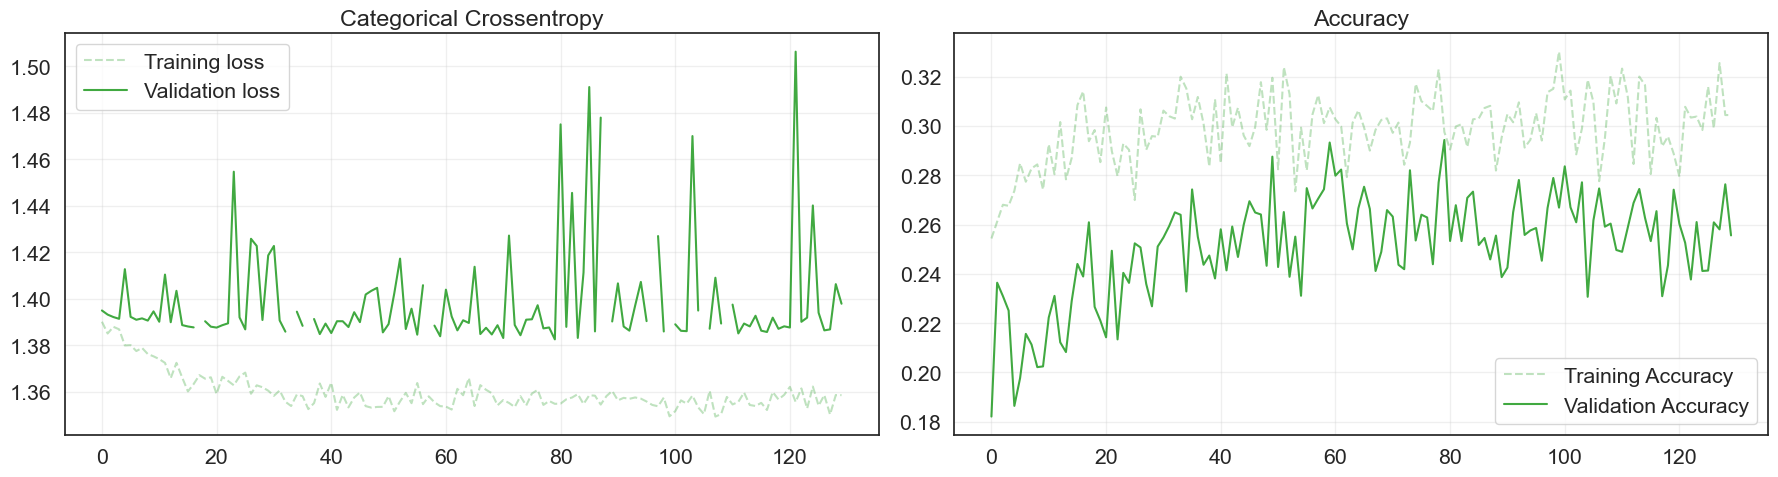

In [209]:
# Plot the results of the transfer learning training
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(tl_history['train_loss'], label='Training loss', alpha=0.3, color='#2ca02c', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Validation loss', alpha=0.9, color="#2ca02c")
ax1.set_title('Categorical Crossentropy') 
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation Accuracy on the second axis
ax2.plot(tl_history['train_acc'], label='Training Accuracy', alpha=0.3, color='#2ca02c', linestyle='--')
ax2.plot(tl_history['val_acc'], label='Validation Accuracy', alpha=0.9, color='#2ca02c')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [210]:
# Make predictions on the test set created inside the training set
test_tl_ds = TissueDataset(X_test, y_test, augmentation=None, normalize_imagenet=True)
test_tl_loader = make_loader(test_tl_ds, BATCH_SIZE, shuffle=False, drop_last=False)

best_val_acc = max(tl_history['val_acc'])
model_path = Path(f"models/transfer_learning_best_model.pt")

if not model_path.exists():
    candidates = sorted(Path("models").glob(f"{experiment_name}_*_model.pt"))
    if candidates:
        model_path = candidates[-1]
    else:
        raise FileNotFoundError(f"No model file matching {model_path.name}")
    
tl_model.load_state_dict(torch.load(model_path, map_location=device))
tl_model.eval()

print(f"Loaded weights from {model_path.name}")

all_test_predictions = []
with torch.no_grad():
    for inputs, _ in test_tl_loader:
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = tl_model(inputs)
        predictions = logits.argmax(dim=1)
        all_test_predictions.append(predictions.cpu().numpy())
all_test_predictions = np.concatenate(all_test_predictions)

# Calculate test metrics
test_f1 = f1_score(y_test, all_test_predictions, average='weighted')
test_precision = precision_score(y_test, all_test_predictions, average='weighted', zero_division=0)
test_recall = recall_score(y_test, all_test_predictions, average='weighted', zero_division=0)

print(f"\nTest Set Performance:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

Loaded weights from transfer_learning_best_model.pt

Test Set Performance:
F1 Score: 0.2830
Precision: 0.3131
Recall: 0.2911


## **Submission**

In [93]:
print(f"\n{'='*60}")
print("TEST IMAGE PROCESSING & SUBMISSION")
print(f"{'='*60}")

# Step 1: Apply masks to test images
# print("\nStep 1: Applying masks to test images...")
# TEST_MASKED_PATH = datasets_path / "test_masked"
# TEST_MASKED_PATH.mkdir(parents=True, exist_ok=True)

# process_batch(str(test_data_path), str(TEST_MASKED_PATH), target_size=(224, 224))

# Step 2: Create patched test images using GRID-BASED extraction (same as training)
TEST_PATCHED_PATH = datasets_path / "test_data_patched_new"
TEST_PATCHED_PATH.mkdir(parents=True, exist_ok=True)

# print("\nStep 2: Extracting patches from test images using grid method...")

test_patch_mapping = []  # Track which patches belong to which image

if "tl_model" in globals():
    print("Using trained transfer learning model for patch extraction")
else:
    print("Using an already trained transfer learning model for patch extraction")
    tl_model = MobileNetV3Small(num_classes, DROPOUT_RATE).to(device)

# Get all test image files
test_image_files = sorted([f for f in test_data_path.iterdir() if f.name.startswith('img_')])
print(f"Found {len(test_image_files)} test images")

# Use the same parameters as training
PATCH_SIZE = 224
OVERLAP = 0.5
MIN_TISSUE_RATIO = 0.05  # Same as training

for img_file in tqdm(test_image_files, desc="Extracting test patches"):
    # Extract image number from filename
    img_number = int(img_file.stem.split('_')[1])
    
    # Find corresponding mask
    mask_name = f"mask_{img_number:04d}.png"
    mask_path = test_data_path / mask_name
    
    if not mask_path.exists():
        tqdm.write(f"Warning: No mask found for {img_file.name}")
        # Track image with no mask
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue
    
    # Load image and mask
    img = cv2.imread(str(img_file))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    if img is None or mask is None:
        tqdm.write(f"Warning: Could not load {img_file.name} or mask")
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue
    
    # Threshold mask
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Extract grid patches using the SAME function as training
    patches = extract_grid_patches(
        img, 
        binary_mask, 
        patch_size=PATCH_SIZE, 
        overlap=OVERLAP, 
        min_tissue_ratio=MIN_TISSUE_RATIO
    )
    
    if len(patches) == 0:
        tqdm.write(f"Warning: No valid patches for {img_file.name}")
        # Still track this image (will use default prediction later)
        test_patch_mapping.append({
            'patch_filename': None,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })
        continue
    
    # Save patches
    for patch_idx, (patch_img, tissue_ratio) in enumerate(patches):
        patch_name = f"img_{img_number:04d}_patch{patch_idx:03d}.png"
        patch_path = TEST_PATCHED_PATH / patch_name
        cv2.imwrite(str(patch_path), patch_img)
        
        # Track mapping
        test_patch_mapping.append({
            'patch_filename': patch_name,
            'original_img_number': img_number,
            'original_img_name': img_file.name
        })

print(f"\nExtracted {len([m for m in test_patch_mapping if m['patch_filename'] is not None])} test patches")
print(f"Images with no patches: {len([m for m in test_patch_mapping if m['patch_filename'] is None])}")

# Step 3: Load test patches and make predictions
print("\nStep 3: Loading test patches for prediction...")

test_patches_list = []
patch_names_list = []

for mapping in tqdm(test_patch_mapping, desc="Loading test patches"):
    if mapping['patch_filename'] is None:
        continue  # Skip images with no patches
        
    patch_path = TEST_PATCHED_PATH / mapping['patch_filename']
    
    if not patch_path.exists():
        continue
    
    # Load patch
    patch_img = cv2.imread(str(patch_path))
    if patch_img is not None:
        # Convert BGR to RGB and normalize
        patch_rgb = cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB) / 255.0
        test_patches_list.append(patch_rgb)
        patch_names_list.append(mapping['patch_filename'])

# Convert to numpy array
X_test_patches = np.array(test_patches_list)
print(f"Loaded {len(X_test_patches)} test patches")
print(f"Test patches shape: {X_test_patches.shape}")

# Step 4: Generate predictions using the trained model
print("\nStep 4: Generating predictions...")

# Use transfer learning model (change to scratch_model if needed)
print("Using transfer learning model")
model_path = Path("models/transfer_learning_best_model.pt")

if not model_path.exists():
    raise FileNotFoundError(f"Model not found at {model_path}")

# Load the best model
tl_model.load_state_dict(torch.load(model_path, map_location=device))
tl_model.eval()
print(f"Loaded model from {model_path.name}")

# Create dataset and dataloader for test patches
test_patches_ds = TissueDataset(
    X_test_patches, 
    np.zeros(len(X_test_patches)),  # Dummy labels
    augmentation=None, 
    normalize_imagenet=True  # Use ImageNet normalization for transfer learning
)

test_patches_loader = make_loader(test_patches_ds, BATCH_SIZE, shuffle=False, drop_last=False)

# Make predictions
patch_predictions = []
with torch.no_grad():
    for inputs, _ in tqdm(test_patches_loader, desc="Predicting patches"):
        inputs = inputs.to(device)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = tl_model(inputs)
        predictions = logits.argmax(dim=1)
        patch_predictions.extend(predictions.cpu().numpy())

patch_predictions = np.array(patch_predictions)
print(f"Generated {len(patch_predictions)} patch predictions")

# Step 5: Aggregate patch predictions to original images
print("\nStep 5: Aggregating patch predictions to original images...")

# Create a mapping from patch filename to prediction
patch_to_prediction = dict(zip(patch_names_list, patch_predictions))

# Group patches by original image
from collections import defaultdict
image_predictions = defaultdict(list)

for mapping in test_patch_mapping:
    patch_name = mapping['patch_filename']
    original_img_name = mapping['original_img_name']
    
    if patch_name is not None and patch_name in patch_to_prediction:
        pred = patch_to_prediction[patch_name]
        image_predictions[original_img_name].append(pred)

# Aggregate predictions using majority voting
final_predictions = {}

for img_name, preds in image_predictions.items():
    if len(preds) > 0:
        # Majority vote
        unique, counts = np.unique(preds, return_counts=True)
        majority_class = unique[np.argmax(counts)]
        final_predictions[img_name] = majority_class

# Decode predictions to labels
final_labels = {}
for img_name, pred in final_predictions.items():
    final_labels[img_name] = label_encoder.inverse_transform([pred])[0]

print(f"Generated predictions for {len(final_labels)} test images")
print(f"Images without predictions: {len(test_image_files) - len(final_labels)}")

# Step 6: Create submission file
print("\nStep 6: Creating submission file...")

# Calculate most common class in training data for default
train_class_counts = np.bincount(y_train)
most_common_class = np.argmax(train_class_counts)
default_label = label_encoder.inverse_transform([most_common_class])[0]

# Get all test image filenames in sorted order
test_filenames = sorted([f.name for f in test_data_path.iterdir() if f.name.startswith('img_')])

# Create submission data
submission_data = []
missing_predictions_count = 0
images_with_default = []

for filename in test_filenames:
    if filename in final_labels:
        label = final_labels[filename]
    else:
        # Use most common training class as default
        print("Warning: the image is removed")
        label = default_label
        missing_predictions_count += 1
        images_with_default.append(filename)
    
    submission_data.append({
        'sample_index': filename,
        'label': label
    })

# Create DataFrame
submission_df = pd.DataFrame(submission_data)

# Save to CSV
submission_path = datasets_path.parent / "submission_tl_MN_grid.csv"
submission_df.to_csv(submission_path, index=False)

print(f"\n{'='*60}")
print(f"SUBMISSION COMPLETE")
print(f"{'='*60}")
print(f"Submission file saved to: {submission_path}")
print(f"Total predictions: {len(submission_df)}")
print(f"Images with model predictions: {len(final_labels)}")
print(f"Images with default predictions: {missing_predictions_count}")

if missing_predictions_count > 0:
    print(f"\nFirst 20 images with default predictions:")
    for img_name in images_with_default[:20]:
        print(f"  {img_name}")
    if missing_predictions_count > 20:
        print(f"  ... and {missing_predictions_count - 20} more")

print(f"\nLabel distribution in submission:")
label_counts = submission_df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    percentage = (count / len(submission_df)) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")

# Verify submission format
print(f"\n{'='*60}")
print(f"Submission Verification")
print(f"{'='*60}")
print(f"Columns: {list(submission_df.columns)}")
print(f"Number of predictions: {len(submission_df)}")
print(f"Number of unique labels: {submission_df['label'].nunique()}")
print(f"Labels used: {sorted(submission_df['label'].unique())}")
print(f"{'='*60}")


TEST IMAGE PROCESSING & SUBMISSION
Using trained transfer learning model for patch extraction
Found 477 test images


Extracting test patches:   4%|▍         | 20/477 [00:00<00:19, 23.23it/s]

Extracting test patches:   8%|▊         | 38/477 [00:01<00:20, 21.78it/s]

Extracting test patches:  11%|█         | 53/477 [00:02<00:19, 22.29it/s]

Extracting test patches:  17%|█▋        | 83/477 [00:04<00:18, 20.93it/s]

Extracting test patches:  19%|█▊        | 89/477 [00:04<00:19, 19.98it/s]

Extracting test patches:  23%|██▎       | 110/477 [00:05<00:15, 24.21it/s]

Extracting test patches:  25%|██▌       | 120/477 [00:05<00:15, 23.03it/s]

Extracting test patches:  30%|███       | 144/477 [00:06<00:14, 22.84it/s]

Extracting test patches:  31%|███▏      | 150/477 [00:07<00:14, 21.83it/s]

Extracting test patches:  37%|███▋      | 177/477 [00:08<00:14, 20.66it/s]

Extracting test patches:  38%|███▊      | 180/477 [00:08<00:13, 21.38it/s]

Extracting test patches:  59%|█████▊    | 280/477 [00:13<00:09, 19.76it/s]

Extracting test patches:  62%|██████▏   | 296/477 [00:14<00:07, 23.46it/s]

Extracting test patches:  69%|██████▉   | 328/477 [00:16<00:06, 22.29it/s]

Extracting test patches:  71%|███████   | 339/477 [00:16<00:07, 19.50it/s]

Extracting test patches:  75%|███████▌  | 360/477 [00:17<00:05, 21.62it/s]

Extracting test patches:  78%|███████▊  | 372/477 [00:18<00:04, 23.35it/s]

Extracting test patches:  81%|████████▏ | 388/477 [00:19<00:04, 21.70it/s]

Extracting test patches:  85%|████████▍ | 404/477 [00:19<00:03, 20.84it/s]

Extracting test patches:  90%|████████▉ | 428/477 [00:21<00:02, 21.14it/s]

Extracting test patches:  91%|█████████ | 434/477 [00:21<00:02, 19.41it/s]

Extracting test patches:  96%|█████████▌| 456/477 [00:22<00:01, 19.33it/s]

Extracting test patches: 100%|██████████| 477/477 [00:23<00:00, 19.96it/s]



Extracted 5215 test patches
Images with no patches: 28

Step 3: Loading test patches for prediction...


Loading test patches: 100%|██████████| 5243/5243 [00:36<00:00, 143.65it/s]


Loaded 5215 test patches
Test patches shape: (5215, 224, 224, 3)

Step 4: Generating predictions...
Using transfer learning model
Loaded model from transfer_learning_best_model.pt


Predicting patches: 100%|██████████| 163/163 [00:07<00:00, 21.12it/s]

Generated 5215 patch predictions

Step 5: Aggregating patch predictions to original images...
Generated predictions for 449 test images
Images without predictions: 28

Step 6: Creating submission file...

SUBMISSION COMPLETE
Submission file saved to: C:\Users\ortol\Desktop\Polimi\ANN_challenge\second_challenge\AN2DL_CH_2\submission_tl_MN_grid.csv
Total predictions: 477
Images with model predictions: 449
Images with default predictions: 28

First 20 images with default predictions:
  img_0017.png
  img_0034.png
  img_0050.png
  img_0080.png
  img_0086.png
  img_0104.png
  img_0107.png
  img_0108.png
  img_0115.png
  img_0117.png
  img_0140.png
  img_0148.png
  img_0173.png
  img_0177.png
  img_0279.png
  img_0293.png
  img_0324.png
  img_0335.png
  img_0358.png
  img_0368.png
  ... and 8 more

Label distribution in submission:
  HER2(+): 158 (33.12%)
  Luminal A: 109 (22.85%)
  Luminal B: 169 (35.43%)
  Triple negative: 41 (8.60%)

Submission Verification
Columns: ['sample_index', 'labe